In [ ]:
from __future__ import annotations
import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel

CSV_PATH = "./csv.csv"
SEED = 42
np.random.seed(SEED)

# 2) Utilidades

def parse_time_from_reading(x: str) -> int:
    """Convierte 'Reading_0' -> 0, 'Reading_3' -> 3."""
    if pd.isna(x):
        return np.nan
    m = re.search(r"(\d+)$", str(x))
    return int(m.group(1)) if m else np.nan

# 3) Carga y features

def clean_and_engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Fechas
    if 'Survey_Date' in df.columns:
        df['Survey_Date'] = pd.to_datetime(df['Survey_Date'], errors='coerce', dayfirst=False)

    # Numéricas
    for col in ['Plant_Height','Basal_Cover','Canopy_Diameter_Max','Canopy_Diameter_Min','Stolons_Number']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Categóricas clave
    for col in ['Evaluation_Unit','Fertilizer_Treatment','Reading_Number','Species_Key',
                'Species_CommonName','Plant_Vigor','Survival_Status','Phenological_Stage']:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # Reordenar para que 'Control' sea base si existe
    try:
        if 'Fertilizer_Treatment' in df.columns and hasattr(df['Fertilizer_Treatment'].dtype, 'categories'):
            cats = list(df['Fertilizer_Treatment'].cat.categories)
            if 'Control' in cats:
                new_order = ['Control'] + [c for c in cats if c != 'Control']
                df['Fertilizer_Treatment'] = df['Fertilizer_Treatment'].cat.reorder_categories(new_order, ordered=False)
    except Exception:
        pass

    # Tiempo (lectura)
    df['time'] = df['Reading_Number'].astype(str).apply(parse_time_from_reading)

    # ID compuesto por seguridad
    if {'Evaluation_Unit','Individual_ID'}.issubset(df.columns):
        df['unit_ind_id'] = df['Evaluation_Unit'].astype(str) + '-' + df['Individual_ID'].astype(str)
    else:
        df['unit_ind_id'] = df['Individual_ID'].astype(str)

    # Áreas derivadas (cm²)
    df['Canopy_Area'] = np.pi/4.0 * df['Canopy_Diameter_Max'] * df['Canopy_Diameter_Min']
    df['Basal_Area']  = np.pi/4.0 * df['Basal_Cover'] * df['Basal_Cover']

    # Supervivencia binaria
    surv_map = {'V':1, 'M':0}
    df['Survival_bin'] = df['Survival_Status'].map(surv_map)

    # Vigor ordinal (B<M<A) + flag A
    vigor_cats = ['B','M','A']
    if 'Plant_Vigor' in df.columns:
        df['Plant_Vigor_cat'] = pd.Categorical(df['Plant_Vigor'], categories=vigor_cats, ordered=True)
        df['vigorA_flag'] = (df['Plant_Vigor'] == 'A').astype('float')

    # Baseline por individuo (Reading_0)
    base = (
        df[df['time'] == 0]
          .groupby('unit_ind_id')
          .agg(base_height=('Plant_Height','mean'),
               base_canopy=('Canopy_Area','mean'),
               base_basal=('Basal_Area','mean'))
    )
    df = df.merge(base, how='left', on='unit_ind_id')

    # Transformaciones log1p para áreas
    for col in ['Canopy_Area','Basal_Area','base_canopy','base_basal']:
        df[f'log1p_{col}'] = np.log1p(df[col])

    return df

# =============================
# 4) EDA mínima
# =============================

def quick_balance(df: pd.DataFrame) -> None:
    pats = ['Fertilizer_Treatment','Species_Key','Reading_Number']
    present = [c for c in pats if c in df.columns]
    if present:
        print("\n[Balance de celdas] n por combinaciones clave:\n")
        print(df.groupby(present, observed=True).size().rename('n').reset_index().head(25))
    if 'Fertilizer_Treatment' in df.columns:
        if hasattr(df['Fertilizer_Treatment'].dtype, 'categories'):
            print("\n[Tratamientos presentes]", list(df['Fertilizer_Treatment'].cat.categories))
        else:
            print("\n[Tratamientos presentes]", sorted(df['Fertilizer_Treatment'].unique()))

# 5) Modelos

def fit_height_mixedlm(df: pd.DataFrame):
    """Altura con efectos aleatorios por individuo; ANCOVA con baseline y efecto del tiempo."""
    sub = df.dropna(subset=['Plant_Height','time','Fertilizer_Treatment','Species_Key','base_height'])
    # Excluir baseline (colinealidad con base_height)
    sub = sub[sub['time'] > 0]
    model = smf.mixedlm(
        "Plant_Height ~ C(Fertilizer_Treatment)*time + C(Species_Key) + base_height",
        data=sub, groups=sub['unit_ind_id']
    )
    try:
        res = model.fit(reml=True, method='lbfgs')
    except Exception as e:
        print(f"\n[Fallback GEE-Gaussian] Altura por error en MixedLM: {e}")
        fam = sm.families.Gaussian()
        cov = sm.cov_struct.Exchangeable()
        gee_mod = smf.gee(
            "Plant_Height ~ C(Fertilizer_Treatment)*time + C(Species_Key) + base_height",
            groups="unit_ind_id", data=sub, family=fam, cov_struct=cov
        )
        res = gee_mod.fit()
    print("\n[MixedLM/GEE] Altura de planta")
    print(res.summary())
    return res, sub

def fit_canopy_mixedlm(df: pd.DataFrame):
    """Área de copa (log1p) con baseline log1p como covariable (ANCOVA)."""
    sub = df.dropna(subset=['log1p_Canopy_Area','time','Fertilizer_Treatment','Species_Key','log1p_base_canopy'])
    # Excluir baseline (colinealidad con log1p_base_canopy)
    sub = sub[sub['time'] > 0]
    model = smf.mixedlm(
        "log1p_Canopy_Area ~ C(Fertilizer_Treatment)*time + C(Species_Key) + log1p_base_canopy",
        data=sub, groups=sub['unit_ind_id']
    )
    try:
        res = model.fit(reml=True, method='lbfgs')
    except Exception as e:
        print(f"\n[Fallback GEE-Gaussian] Área de copa por error en MixedLM: {e}")
        fam = sm.families.Gaussian()
        cov = sm.cov_struct.Exchangeable()
        gee_mod = smf.gee(
            "log1p_Canopy_Area ~ C(Fertilizer_Treatment)*time + C(Species_Key) + log1p_base_canopy",
            groups="unit_ind_id", data=sub, family=fam, cov_struct=cov
        )
        res = gee_mod.fit()
    print("\n[MixedLM/GEE] log1p(Área de copa)")
    print(res.summary())
    return res, sub

def fit_survival_gee(df: pd.DataFrame):
    """Supervivencia con GEE binomial y estructura exchangeable por individuo."""
    sub = df.dropna(subset=['Survival_bin','time','Fertilizer_Treatment','Species_Key'])
    fam = sm.families.Binomial()
    cov = sm.cov_struct.Exchangeable()
    model = smf.gee(
        "Survival_bin ~ C(Fertilizer_Treatment)*time + C(Species_Key)",
        groups="unit_ind_id",
        data=sub,
        family=fam,
        cov_struct=cov
    )
    res = model.fit()
    print("\n[GEE] Supervivencia (logit)")
    print(res.summary())
    return res, sub

def fit_vigor_ordinal(df: pd.DataFrame):
    """Vigor ordinal (B<M<A) con OrderedModel (logit) y exog numérica sin constante."""
    if 'Plant_Vigor_cat' not in df.columns:
        print("\n[OrderedModel] No hay Plant_Vigor para estimar modelo ordinal.")
        return None, None, None

    sub = df.dropna(subset=['Plant_Vigor_cat','time','Fertilizer_Treatment','Species_Key']).copy()

    # Endog como códigos 0/1/2 (B/M/A)
    y = sub['Plant_Vigor_cat'].cat.codes.astype(int)
    if pd.Series(y).nunique() < 2:
        print("\n[OrderedModel] Menos de dos categorías presentes en Plant_Vigor. Se omite.")
        return None, None, None

    # Exog: dummies para tratamiento y especie; time como numérica
    X = pd.get_dummies(sub[['Fertilizer_Treatment','Species_Key']], drop_first=True)
    X['time'] = pd.to_numeric(sub['time'], errors='coerce').astype(float)

    # SIN constante para OrderedModel
    X = X.astype(float).values
    y = np.asarray(y, dtype=int)

    model = OrderedModel(y, X, distr='logit')
    res = model.fit(method='bfgs', disp=False)
    print("\n[OrderedModel] Vigor (ordinal logit)")
    print(res.summary())
    return res, sub, X

def fit_stolons_gee_nb(df: pd.DataFrame):
    """Estolones (negativo binomial, solo Alchemilla pinnata)."""
    sub = df[df['Species_Key'].isin(['Alc_pin','Al_pin'])].dropna(subset=['Stolons_Number','time','Fertilizer_Treatment'])
    if sub.empty:
        print("\n[GEE-NB] No hay registros de Alchemilla pinnata para estolones.")
        return None, None
    fam = sm.families.NegativeBinomial()
    cov = sm.cov_struct.Exchangeable()
    model = smf.gee(
        "Stolons_Number ~ C(Fertilizer_Treatment)*time",
        groups="unit_ind_id",
        data=sub,
        family=fam,
        cov_struct=cov
    )
    res = model.fit()
    print("\n[GEE-NB] Estolones (Alchemilla)")
    print(res.summary())
    return res, sub

# 6) Contrastes y OR

def contrast_vs_control_lmm(res, at_time=None):
    """
    Efectos de tratamiento vs 'Control' (si es base).
    Si hay interacción con 'time' y se pasa at_time (int):
    efecto = beta_treat + beta_treat:time * at_time
    """
    params = res.params
    cov = res.cov_params()
    treat_coefs = [p for p in params.index if p.startswith('C(Fertilizer_Treatment)') and ':time' not in p]

    def label_from_param(p):
        m = re.search(r"\[T\.(.+)\]", p)
        return m.group(1) if m else p

    rows = []
    for coef_name in treat_coefs:
        treat = label_from_param(coef_name)
        est = params.get(coef_name, 0.0)
        var = cov.loc[coef_name, coef_name] if coef_name in cov.index else 0.0
        inter_name = f"{coef_name}:time"
        if at_time is not None and inter_name in params.index:
            est = est + at_time * params[inter_name]
            var = var + (at_time**2) * cov.loc[inter_name, inter_name] + 2*at_time*cov.loc[coef_name, inter_name]
        se = np.sqrt(max(var, 0.0))
        ci_lo, ci_hi = est - 1.96*se, est + 1.96*se
        rows.append({'treatment': treat, 'effect': est, 'se': se, 'ci_lo': ci_lo, 'ci_hi': ci_hi})
    out = pd.DataFrame(rows).sort_values('effect', ascending=False)
    return out

def odds_ratios_from_gee(res) -> pd.DataFrame:
    """Convierte coeficientes logit en OR con IC95% (solo términos de tratamiento)."""
    params = res.params
    cov = res.cov_params()
    rows = []
    for name, b in params.items():
        if name.startswith('C(Fertilizer_Treatment)') and name in cov.index:
            se = float(np.sqrt(cov.loc[name, name]))
            lo, hi = b - 1.96*se, b + 1.96*se
            rows.append({'term': name, 'OR': float(np.exp(b)), 'CI95_lo': float(np.exp(lo)), 'CI95_hi': float(np.exp(hi))})
    return pd.DataFrame(rows).sort_values('OR', ascending=False)

# =============================
# 7) Índice multi-criterio
# =============================

def multicriteria_index(df: pd.DataFrame, weights=None, post_only=True) -> pd.DataFrame:
    """
    Índice por tratamiento combinando métricas normalizadas (post-baseline):
    - Altura media, log1p(Área de copa) media, P(supervivencia=1), P(vigor=A)
    """
    if weights is None:
        weights = {'height': 0.50, 'canopy': 0.20, 'survival': 0.20, 'vigorA': 0.10}

    d = df.copy()
    if post_only:
        d = d[d['time'] > 0]

    # Asegurar tipos numéricos
    for c in ['Plant_Height', 'log1p_Canopy_Area', 'Survival_bin', 'vigorA_flag']:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors='coerce')

    # Si no existiera el flag, créalo (todo NaN si no hay Plant_Vigor)
    if 'vigorA_flag' not in d.columns:
        if 'Plant_Vigor' in d.columns:
            d['vigorA_flag'] = (d['Plant_Vigor'].astype(str) == 'A').astype(float)
        else:
            d['vigorA_flag'] = np.nan

    # Promedios solo de columnas NUMÉRICAS (evita mean sobre categóricas)
    g = d.groupby('Fertilizer_Treatment', observed=True)
    base = g[['Plant_Height', 'log1p_Canopy_Area', 'Survival_bin']].mean(numeric_only=True)
    vigor = g['vigorA_flag'].mean()

    agg = base.join(vigor.rename('vigorA'))

    # Z-score seguro
    std = agg.std(ddof=0).replace(0, np.nan)
    z = ((agg - agg.mean()) / std).fillna(0)

    w = pd.Series(weights).reindex(z.columns).fillna(0.0)
    score = (z * w).sum(axis=1)

    return agg.assign(score=score).sort_values('score', ascending=False)


# =============================
# 8) Main
# =============================
if __name__ == "__main__":
    df_raw = pd.read_csv(CSV_PATH)
    df = clean_and_engineer(df_raw)

    # Filtro
    mask = df['Evaluation_Unit'].astype(str).str.strip().str.upper().str.startswith('TAM')
    df = df.loc[mask].copy()

    for col in df.select_dtypes(['category']).columns:
      df[col] = df[col].cat.remove_unused_categories()

    print("\nDimensiones:", df.shape)
    quick_balance(df)

    # Modelos
    res_h, sub_h = fit_height_mixedlm(df)
    res_c, sub_c = fit_canopy_mixedlm(df)
    res_s, sub_s = fit_survival_gee(df)
    res_v, sub_v, Xv = fit_vigor_ordinal(df)
    res_nb, sub_nb = fit_stolons_gee_nb(df)

    # Contrastes a tiempo final (si existe)
    tmax = int(df['time'].max()) if pd.notnull(df['time']).any() else None
    if tmax is not None:
        print(f"\n[Contrastes] Altura vs control (si existe) a t={tmax}")
        print(contrast_vs_control_lmm(res_h, at_time=tmax))
        print(f"\n[Contrastes] log1p(Área de copa) vs control (si existe) a t={tmax}")
        print(contrast_vs_control_lmm(res_c, at_time=tmax))

    # OR de supervivencia por tratamiento
    print("\n[Odds Ratios] Supervivencia (tratamientos)")
    print(odds_ratios_from_gee(res_s))

    # Índice multi-criterio
    print("\n[Índice multi-criterio] Ranking por tratamiento (post-baseline)")
    print(multicriteria_index(df))



Dimensiones: (2800, 32)

[Balance de celdas] n por combinaciones clave:

   Fertilizer_Treatment Species_Key Reading_Number   n
0               Control      Al_pin      Reading_0  14
1               Control      Al_pin      Reading_1  14
2               Control      Al_pin      Reading_2  14
3               Control      Al_pin      Reading_3  14
4               Control      Al_pin      Reading_4  14
5               Control      Al_pin      Reading_5  14
6               Control      Al_pin      Reading_6  14
7               Control     Cin_cur      Reading_0  16
8               Control     Cin_cur      Reading_1  16
9               Control     Cin_cur      Reading_2  16
10              Control     Cin_cur      Reading_3  16
11              Control     Cin_cur      Reading_4  16
12              Control     Cin_cur      Reading_5  16
13              Control     Cin_cur      Reading_6  16
14              Control     Cin_vic      Reading_0  14
15              Control     Cin_vic      Readi

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



[Fallback GEE-Gaussian] Altura por error en MixedLM: Singular matrix

[MixedLM/GEE] Altura de planta
                               GEE Regression Results                              
Dep. Variable:                Plant_Height   No. Observations:                 2315
Model:                                 GEE   No. clusters:                      400
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   6
Family:                           Gaussian   Mean cluster size:                 5.8
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Thu, 16 Oct 2025   Scale:                           3.903
Covariance type:                    robust   Time:                         20:13:08
                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



[Fallback GEE-Gaussian] Área de copa por error en MixedLM: Singular matrix

[MixedLM/GEE] log1p(Área de copa)
                               GEE Regression Results                              
Dep. Variable:           log1p_Canopy_Area   No. Observations:                 2309
Model:                                 GEE   No. clusters:                      400
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   6
Family:                           Gaussian   Mean cluster size:                 5.8
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Thu, 16 Oct 2025   Scale:                           0.106
Covariance type:                    robust   Time:                         20:13:09
                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



[Export] PNGs guardados en 'out/'


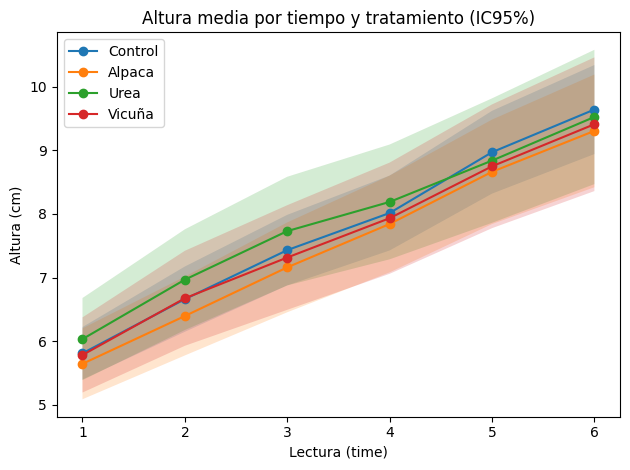

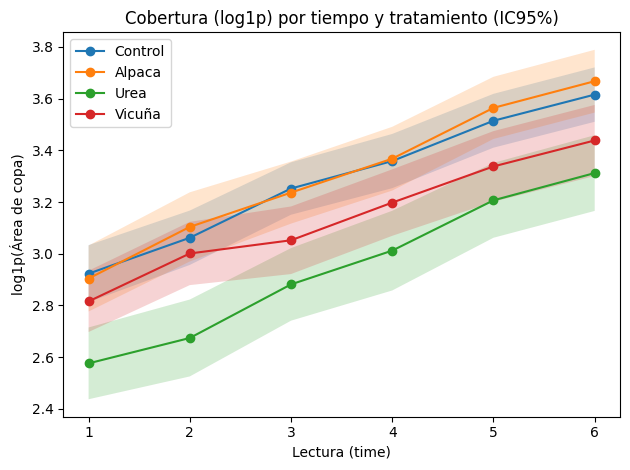

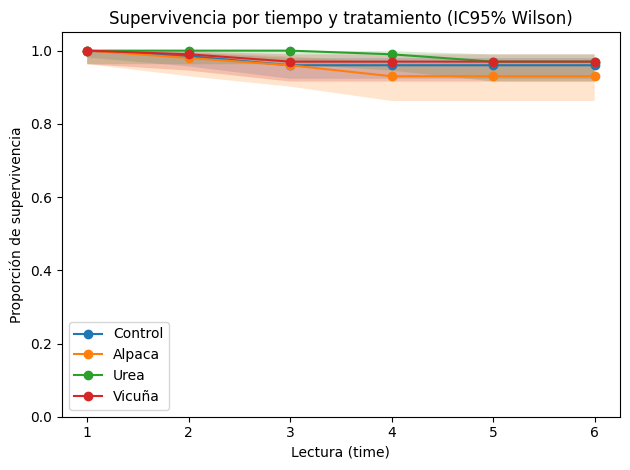

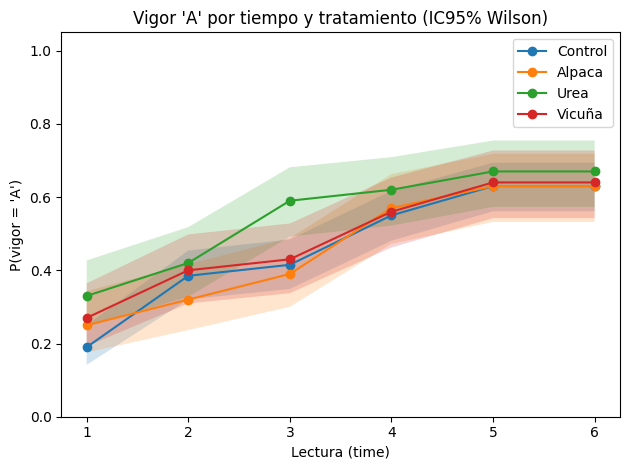

In [ ]:
# =========  Gráficos (matplotlib)  =========
import os, numpy as np, matplotlib.pyplot as plt
from math import sqrt
os.makedirs("out", exist_ok=True)

d_post = df[df['time'] > 0].copy()

# Asegurar numéricos antes de agrupar
for c in ['Plant_Height','log1p_Canopy_Area','Survival_bin','vigorA_flag']:
    if c in d_post.columns:
        d_post[c] = pd.to_numeric(d_post[c], errors='coerce')

def summarize_mean_ci(data, group_cols, target):
    tmp = (data.groupby(group_cols, observed=True)[target]
              .agg(['mean','count','std']).reset_index())
    tmp['se'] = tmp['std'] / tmp['count'].clip(lower=1).pow(0.5)
    tmp['lo'] = tmp['mean'] - 1.96*tmp['se']
    tmp['hi'] = tmp['mean'] + 1.96*tmp['se']
    return tmp.drop(columns=['std','se'])

def wilson_ci(k, n, z=1.96):
    if n == 0: return np.nan, np.nan, np.nan
    p = k/n
    denom = 1 + z*z/n
    center = (p + z*z/(2*n))/denom
    half = z/denom * sqrt(max(p*(1-p)/n + z*z/(4*n*n), 0))
    return p, center-half, center+half

# 1) Altura
summ_h = summarize_mean_ci(d_post, ['time','Fertilizer_Treatment'], 'Plant_Height')
plt.figure()
for tr in summ_h['Fertilizer_Treatment'].unique():
    sub = summ_h[summ_h['Fertilizer_Treatment']==tr].sort_values('time')
    plt.plot(sub['time'], sub['mean'], marker='o', label=tr)
    plt.fill_between(sub['time'], sub['lo'], sub['hi'], alpha=0.2)
plt.xlabel("Lectura (time)"); plt.ylabel("Altura (cm)")
plt.title("Altura media por tiempo y tratamiento (IC95%)")
plt.legend(); plt.tight_layout(); plt.savefig("out/altura_por_tiempo_trat.png", dpi=150)

# 2) log1p(Área de copa)
summ_c = summarize_mean_ci(d_post, ['time','Fertilizer_Treatment'], 'log1p_Canopy_Area')
plt.figure()
for tr in summ_c['Fertilizer_Treatment'].unique():
    sub = summ_c[summ_c['Fertilizer_Treatment']==tr].sort_values('time')
    plt.plot(sub['time'], sub['mean'], marker='o', label=tr)
    plt.fill_between(sub['time'], sub['lo'], sub['hi'], alpha=0.2)
plt.xlabel("Lectura (time)"); plt.ylabel("log1p(Área de copa)")
plt.title("Cobertura (log1p) por tiempo y tratamiento (IC95%)")
plt.legend(); plt.tight_layout(); plt.savefig("out/copa_por_tiempo_trat.png", dpi=150)

# 3) Supervivencia (Wilson)
summ_s = (
    d_post.groupby(['time','Fertilizer_Treatment'], observed=True)['Survival_bin']
         .agg(sum='sum', count='count')  # <- evita choque con dtype
         .reset_index()
)
summ_s[['prop','lo','hi']] = summ_s.apply(lambda r: pd.Series(wilson_ci(r['sum'], r['count'])), axis=1)
plt.figure()
for tr in summ_s['Fertilizer_Treatment'].unique():
    sub = summ_s[summ_s['Fertilizer_Treatment']==tr].sort_values('time')
    plt.plot(sub['time'], sub['prop'], marker='o', label=tr)
    plt.fill_between(sub['time'], sub['lo'], sub['hi'], alpha=0.2)
plt.ylim(0,1.05); plt.xlabel("Lectura (time)"); plt.ylabel("Proporción de supervivencia")
plt.title("Supervivencia por tiempo y tratamiento (IC95% Wilson)")
plt.legend(); plt.tight_layout(); plt.savefig("out/supervivencia_por_tiempo_trat.png", dpi=150)

# 4) Vigor A (Wilson)
if 'vigorA_flag' in d_post.columns:
    summ_v = (
        d_post.groupby(['time','Fertilizer_Treatment'], observed=True)['vigorA_flag']
             .agg(sum='sum', count='count').reset_index()
    )
    summ_v[['prop','lo','hi']] = summ_v.apply(lambda r: pd.Series(wilson_ci(r['sum'], r['count'])), axis=1)
    plt.figure()
    for tr in summ_v['Fertilizer_Treatment'].unique():
        sub = summ_v[summ_v['Fertilizer_Treatment']==tr].sort_values('time')
        plt.plot(sub['time'], sub['prop'], marker='o', label=tr)
        plt.fill_between(sub['time'], sub['lo'], sub['hi'], alpha=0.2)
    plt.ylim(0,1.05); plt.xlabel("Lectura (time)"); plt.ylabel("P(vigor = 'A')")
    plt.title("Vigor 'A' por tiempo y tratamiento (IC95% Wilson)")
    plt.legend(); plt.tight_layout(); plt.savefig("out/vigorA_por_tiempo_trat.png", dpi=150)

print("\n[Export] PNGs guardados en 'out/'")


In [ ]:

from __future__ import annotations
import os
import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel
import matplotlib.pyplot as plt
from math import sqrt

# =============================
# 1) Configuración
# =============================
CSV_PATH = "./csv.csv"
SEED = 42
np.random.seed(SEED)

# =============================
# 2) Utilidades
# =============================

def parse_time_from_reading(x: str) -> int:
    """Convierte 'Reading_0' -> 0, 'Reading_3' -> 3."""
    if pd.isna(x):
        return np.nan
    m = re.search(r"(\d+)$", str(x))
    return int(m.group(1)) if m else np.nan

def mean_ci_series(s: pd.Series) -> pd.Series:
    x = np.asarray(pd.to_numeric(s, errors='coerce').dropna())
    n = x.size
    if n == 0:
        return pd.Series({'mean': np.nan, 'lo': np.nan, 'hi': np.nan, 'count': 0})
    m = x.mean()
    se = x.std(ddof=1) / np.sqrt(n) if n > 1 else 0.0
    lo, hi = m - 1.96*se, m + 1.96*se
    return pd.Series({'mean': m, 'lo': lo, 'hi': hi, 'count': n})

def summarize_mean_ci(df: pd.DataFrame, group_cols, target):
    tmp = (df.groupby(group_cols, observed=True)[target]
             .agg(['mean','count','std'])
             .reset_index())
    tmp['se'] = tmp['std'] / tmp['count'].clip(lower=1).pow(0.5)
    tmp['lo'] = tmp['mean'] - 1.96*tmp['se']
    tmp['hi'] = tmp['mean'] + 1.96*tmp['se']
    return tmp.drop(columns=['std','se'])

def wilson_ci(k, n, z=1.96):
    if n == 0: return np.nan, np.nan, np.nan
    p = k/n
    denom = 1 + z*z/n
    center = (p + z*z/(2*n))/denom
    half = z/denom * sqrt(max(p*(1-p)/n + z*z/(4*n*n), 0))
    return p, center-half, center+half

# =============================
# 3) Carga y features
# =============================

def clean_and_engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Fechas
    if 'Survey_Date' in df.columns:
        df['Survey_Date'] = pd.to_datetime(df['Survey_Date'], errors='coerce', dayfirst=False)

    # Numéricas
    for col in ['Plant_Height','Basal_Cover','Canopy_Diameter_Max','Canopy_Diameter_Min','Stolons_Number']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Categóricas clave
    for col in ['Evaluation_Unit','Fertilizer_Treatment','Reading_Number','Species_Key',
                'Species_CommonName','Plant_Vigor','Survival_Status','Phenological_Stage']:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # Reordenar para que 'Control' sea base si existe
    try:
        if 'Fertilizer_Treatment' in df.columns and hasattr(df['Fertilizer_Treatment'].dtype, 'categories'):
            cats = list(df['Fertilizer_Treatment'].cat.categories)
            if 'Control' in cats:
                new_order = ['Control'] + [c for c in cats if c != 'Control']
                df['Fertilizer_Treatment'] = df['Fertilizer_Treatment'].cat.reorder_categories(new_order, ordered=False)
    except Exception:
        pass

    # Tiempo (lectura)
    df['time'] = df['Reading_Number'].astype(str).apply(parse_time_from_reading)

    # ID compuesto
    if {'Evaluation_Unit','Individual_ID'}.issubset(df.columns):
        df['unit_ind_id'] = df['Evaluation_Unit'].astype(str) + '-' + df['Individual_ID'].astype(str)
    else:
        df['unit_ind_id'] = df['Individual_ID'].astype(str)

    # Áreas derivadas (cm²)
    df['Canopy_Area'] = np.pi/4.0 * df['Canopy_Diameter_Max'] * df['Canopy_Diameter_Min']
    df['Basal_Area']  = np.pi/4.0 * df['Basal_Cover'] * df['Basal_Cover']

    # Supervivencia binaria -> numérico
    surv_map = {'V':1, 'M':0}
    df['Survival_bin'] = df['Survival_Status'].map(surv_map).astype(float)

    # Vigor ordinal (B<M<A) + flag A numérica
    vigor_cats = ['B','M','A']
    if 'Plant_Vigor' in df.columns:
        df['Plant_Vigor_cat'] = pd.Categorical(df['Plant_Vigor'], categories=vigor_cats, ordered=True)
        df['vigorA_flag'] = (df['Plant_Vigor'].astype(str) == 'A').astype(float)

    # Baseline por individuo (Reading_0)
    base = (
        df[df['time'] == 0]
          .groupby('unit_ind_id')
          .agg(base_height=('Plant_Height','mean'),
               base_canopy=('Canopy_Area','mean'),
               base_basal=('Basal_Area','mean'))
    )
    df = df.merge(base, how='left', on='unit_ind_id')

    # Transformaciones log1p para áreas
    for col in ['Canopy_Area','Basal_Area','base_canopy','base_basal']:
        df[f'log1p_{col}'] = np.log1p(df[col])

    return df

# =============================
# 4) EDA mínima
# =============================

def quick_balance(df: pd.DataFrame) -> None:
    pats = ['Fertilizer_Treatment','Species_Key','Reading_Number']
    present = [c for c in pats if c in df.columns]
    if present:
        print("\n[Balance de celdas] n por combinaciones clave:\n")
        print(df.groupby(present, observed=True).size().rename('n').reset_index().head(25))
    if 'Fertilizer_Treatment' in df.columns:
        if hasattr(df['Fertilizer_Treatment'].dtype, 'categories'):
            print("\n[Tratamientos presentes]", list(df['Fertilizer_Treatment'].cat.categories))
        else:
            print("\n[Tratamientos presentes]", sorted(df['Fertilizer_Treatment'].unique()))

# =============================
# 5) Modelos (por especie)
# =============================

def fit_height_mixedlm_species(df: pd.DataFrame):
    """Altura (por especie): MixedLM ANCOVA con baseline y time; sin dummies de especie."""
    sub = df.dropna(subset=['Plant_Height','time','Fertilizer_Treatment','base_height']).copy()
    sub = sub[sub['time'] > 0]  # excluye baseline por colinealidad con base_height
    if sub.empty:
        print("[Altura] Sin datos post-baseline.")
        return None, sub
    model = smf.mixedlm(
        "Plant_Height ~ C(Fertilizer_Treatment)*time + base_height",
        data=sub, groups=sub['unit_ind_id']
    )
    try:
        res = model.fit(reml=True, method='lbfgs')
    except Exception as e:
        print(f"[Fallback GEE-Gaussian] Altura por error en MixedLM: {e}")
        fam = sm.families.Gaussian()
        cov = sm.cov_struct.Exchangeable()
        gee_mod = smf.gee(
            "Plant_Height ~ C(Fertilizer_Treatment)*time + base_height",
            groups="unit_ind_id", data=sub, family=fam, cov_struct=cov
        )
        res = gee_mod.fit()
    return res, sub

def fit_canopy_mixedlm_species(df: pd.DataFrame):
    """Área de copa log1p (por especie): MixedLM ANCOVA con baseline log1p y time."""
    sub = df.dropna(subset=['log1p_Canopy_Area','time','Fertilizer_Treatment','log1p_base_canopy']).copy()
    sub = sub[sub['time'] > 0]
    if sub.empty:
        print("[Copa] Sin datos post-baseline.")
        return None, sub
    model = smf.mixedlm(
        "log1p_Canopy_Area ~ C(Fertilizer_Treatment)*time + log1p_base_canopy",
        data=sub, groups=sub['unit_ind_id']
    )
    try:
        res = model.fit(reml=True, method='lbfgs')
    except Exception as e:
        print(f"[Fallback GEE-Gaussian] Copa por error en MixedLM: {e}")
        fam = sm.families.Gaussian()
        cov = sm.cov_struct.Exchangeable()
        gee_mod = smf.gee(
            "log1p_Canopy_Area ~ C(Fertilizer_Treatment)*time + log1p_base_canopy",
            groups="unit_ind_id", data=sub, family=fam, cov_struct=cov
        )
        res = gee_mod.fit()
    return res, sub

def fit_survival_gee_species(df: pd.DataFrame):
    """Supervivencia (por especie): GEE Binomial con C(Fertilizer_Treatment)*time."""
    sub = df.dropna(subset=['Survival_bin','time','Fertilizer_Treatment']).copy()
    if sub.empty:
        print("[Supervivencia] Sin datos.")
        return None, sub
    fam = sm.families.Binomial()
    cov = sm.cov_struct.Exchangeable()
    model = smf.gee(
        "Survival_bin ~ C(Fertilizer_Treatment)*time",
        groups="unit_ind_id",
        data=sub,
        family=fam,
        cov_struct=cov
    )
    res = model.fit()
    return res, sub

def fit_vigor_ordinal_species(df: pd.DataFrame):
    """Vigor ordinal (B<M<A) por especie: OrderedModel con exog = dummies de tratamiento + time (sin constante)."""
    if 'Plant_Vigor_cat' not in df.columns:
        print("[Vigor] No hay Plant_Vigor.")
        return None, None, None
    sub = df.dropna(subset=['Plant_Vigor_cat','time','Fertilizer_Treatment']).copy()
    if sub.empty:
        print("[Vigor] Sin datos.")
        return None, None, None

    y = sub['Plant_Vigor_cat'].cat.codes.astype(int)
    if pd.Series(y).nunique() < 2:
        print("[Vigor] Menos de dos categorías; se omite.")
        return None, None, None

    X = pd.get_dummies(sub[['Fertilizer_Treatment']], drop_first=True)
    X['time'] = pd.to_numeric(sub['time'], errors='coerce').astype(float)
    X = X.astype(float).values
    y = np.asarray(y, dtype=int)

    model = OrderedModel(y, X, distr='logit')
    res = model.fit(method='bfgs', disp=False)
    return res, sub, X

def fit_stolons_gee_nb_species(df: pd.DataFrame, species_key: str):
    """Estolones (solo Alchemilla pinnata)."""
    if species_key not in ['Alc_pin','Al_pin']:
        return None, None
    sub = df.dropna(subset=['Stolons_Number','time','Fertilizer_Treatment']).copy()
    if sub.empty:
        print("[Estolones] Sin datos para Alchemilla en esta especie.")
        return None, None
    fam = sm.families.NegativeBinomial(alpha=1.0)  # fija alpha para evitar warning
    cov = sm.cov_struct.Exchangeable()
    model = smf.gee(
        "Stolons_Number ~ C(Fertilizer_Treatment)*time",
        groups="unit_ind_id",
        data=sub,
        family=fam,
        cov_struct=cov
    )
    res = model.fit()
    return res, sub

# =============================
# 6) Contrastes y OR
# =============================

def contrast_vs_control_lmm(res, at_time=None):
    """
    Efectos de tratamiento vs 'Control' (si es base).
    Si hay interacción con 'time' y se pasa at_time (int):
      efecto = beta_treat + beta_treat:time * at_time
    """
    if res is None:
        return pd.DataFrame()
    params = res.params
    cov = res.cov_params()
    treat_coefs = [p for p in params.index if p.startswith('C(Fertilizer_Treatment)') and ':time' not in p]

    def label_from_param(p):
        m = re.search(r"\[T\.(.+)\]", p)
        return m.group(1) if m else p

    rows = []
    for coef_name in treat_coefs:
        treat = label_from_param(coef_name)
        est = params.get(coef_name, 0.0)
        var = cov.loc[coef_name, coef_name] if coef_name in cov.index else 0.0
        inter_name = f"{coef_name}:time"
        if at_time is not None and inter_name in params.index:
            est = est + at_time * params[inter_name]
            var = var + (at_time**2) * cov.loc[inter_name, inter_name] + 2*at_time*cov.loc[coef_name, inter_name]
        se = float(np.sqrt(max(var, 0.0)))
        ci_lo, ci_hi = est - 1.96*se, est + 1.96*se
        rows.append({'treatment': treat, 'effect': float(est), 'se': se, 'ci_lo': float(ci_lo), 'ci_hi': float(ci_hi)})
    return pd.DataFrame(rows).sort_values('effect', ascending=False)

def odds_ratios_from_gee(res) -> pd.DataFrame:
    """Convierte coeficientes logit en OR con IC95% (solo términos de tratamiento)."""
    if res is None:
        return pd.DataFrame()
    params = res.params
    cov = res.cov_params()
    rows = []
    for name, b in params.items():
        if name.startswith('C(Fertilizer_Treatment)') and name in cov.index:
            se = float(np.sqrt(cov.loc[name, name]))
            lo, hi = b - 1.96*se, b + 1.96*se
            rows.append({'term': name, 'OR': float(np.exp(b)), 'CI95_lo': float(np.exp(lo)), 'CI95_hi': float(np.exp(hi))})
    return pd.DataFrame(rows).sort_values('OR', ascending=False)

# =============================
# 7) Índice multi-criterio (por especie)
# =============================

def multicriteria_index(df: pd.DataFrame, weights=None, post_only=True) -> pd.DataFrame:
    """
    Índice por tratamiento combinando métricas normalizadas (post-baseline):
    - Altura media, log1p(Área de copa) media, P(supervivencia=1), P(vigor=A)
    """
    if df.empty:
        return pd.DataFrame()
    if weights is None:
        weights = {'height': 0.50, 'canopy': 0.20, 'survival': 0.20, 'vigorA': 0.10}

    d = df.copy()
    if post_only:
        d = d[d['time'] > 0]

    for c in ['Plant_Height', 'log1p_Canopy_Area', 'Survival_bin', 'vigorA_flag']:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors='coerce')

    if 'vigorA_flag' not in d.columns:
        if 'Plant_Vigor' in d.columns:
            d['vigorA_flag'] = (d['Plant_Vigor'].astype(str) == 'A').astype(float)
        else:
            d['vigorA_flag'] = np.nan

    g = d.groupby('Fertilizer_Treatment', observed=True)
    base = g[['Plant_Height', 'log1p_Canopy_Area', 'Survival_bin']].mean(numeric_only=True)
    vigor = g['vigorA_flag'].mean()

    agg = base.join(vigor.rename('vigorA'))

    # Z-score seguro
    std = agg.std(ddof=0).replace(0, np.nan)
    z = ((agg - agg.mean()) / std).fillna(0)

    w = pd.Series(weights).reindex(z.columns).fillna(0.0)
    score = (z * w).sum(axis=1)

    return agg.assign(score=score).sort_values('score', ascending=False)

# =============================
# 8) Gráficos (por especie)
# =============================

def make_species_plots(sdf: pd.DataFrame, outdir: str):
    os.makedirs(outdir, exist_ok=True)
    d_post = sdf[sdf['time'] > 0].copy()
    for c in ['Plant_Height','log1p_Canopy_Area','Survival_bin','vigorA_flag']:
        if c in d_post.columns:
            d_post[c] = pd.to_numeric(d_post[c], errors='coerce')

    # Altura
    summ_h = summarize_mean_ci(d_post, ['time','Fertilizer_Treatment'], 'Plant_Height')
    if not summ_h.empty:
        plt.figure()
        for tr in summ_h['Fertilizer_Treatment'].unique():
            sub = summ_h[summ_h['Fertilizer_Treatment']==tr].sort_values('time')
            plt.plot(sub['time'], sub['mean'], marker='o', label=tr)
            plt.fill_between(sub['time'], sub['lo'], sub['hi'], alpha=0.2)
        plt.xlabel("Lectura (time)"); plt.ylabel("Altura (cm)")
        plt.title("Altura por tiempo y tratamiento")
        plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(outdir, "altura_tiempo.png"), dpi=150); plt.close()

    # log1p(Área de copa)
    summ_c = summarize_mean_ci(d_post, ['time','Fertilizer_Treatment'], 'log1p_Canopy_Area')
    if not summ_c.empty:
        plt.figure()
        for tr in summ_c['Fertilizer_Treatment'].unique():
            sub = summ_c[summ_c['Fertilizer_Treatment']==tr].sort_values('time')
            plt.plot(sub['time'], sub['mean'], marker='o', label=tr)
            plt.fill_between(sub['time'], sub['lo'], sub['hi'], alpha=0.2)
        plt.xlabel("Lectura (time)"); plt.ylabel("log1p(Área de copa)")
        plt.title("Cobertura (log1p) por tiempo y tratamiento")
        plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(outdir, "copa_tiempo.png"), dpi=150); plt.close()

    # Supervivencia (Wilson)
    if 'Survival_bin' in d_post.columns:
        ss = (d_post.groupby(['time','Fertilizer_Treatment'], observed=True)['Survival_bin']
                    .agg(sum='sum', count='count').reset_index())
        if not ss.empty:
            ss[['prop','lo','hi']] = ss.apply(lambda r: pd.Series(wilson_ci(r['sum'], r['count'])), axis=1)
            plt.figure()
            for tr in ss['Fertilizer_Treatment'].unique():
                sub = ss[ss['Fertilizer_Treatment']==tr].sort_values('time')
                plt.plot(sub['time'], sub['prop'], marker='o', label=tr)
                plt.fill_between(sub['time'], sub['lo'], sub['hi'], alpha=0.2)
            plt.ylim(0,1.05); plt.xlabel("Lectura"); plt.ylabel("Proporción de supervivencia")
            plt.title("Supervivencia por tiempo y tratamiento")
            plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(outdir, "supervivencia_tiempo.png"), dpi=150); plt.close()

    # Vigor A (Wilson)
    if 'vigorA_flag' in d_post.columns:
        sv = (d_post.groupby(['time','Fertilizer_Treatment'], observed=True)['vigorA_flag']
                    .agg(sum='sum', count='count').reset_index())
        if not sv.empty:
            sv[['prop','lo','hi']] = sv.apply(lambda r: pd.Series(wilson_ci(r['sum'], r['count'])), axis=1)
            plt.figure()
            for tr in sv['Fertilizer_Treatment'].unique():
                sub = sv[sv['Fertilizer_Treatment']==tr].sort_values('time')
                plt.plot(sub['time'], sub['prop'], marker='o', label=tr)
                plt.fill_between(sub['time'], sub['lo'], sub['hi'], alpha=0.2)
            plt.ylim(0,1.05); plt.xlabel("Lectura"); plt.ylabel("P(vigor='A')")
            plt.title("Vigor 'A' por tiempo y tratamiento")
            plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(outdir, "vigorA_tiempo.png"), dpi=150); plt.close()

# =============================
# 9) Runner por especie
# =============================

def run_species_analysis(df: pd.DataFrame, species_key: str, out_base: str = "out_by_species"):
    sdf = df[df['Species_Key'].astype(str) == species_key].copy()
    if sdf.empty:
        print(f"\n=== {species_key} ===\nSin datos para esta especie.")
        return

    # Limpia categorías
    for col in sdf.select_dtypes(['category']).columns:
        sdf[col] = sdf[col].cat.remove_unused_categories()

    print(f"\n=== Especie: {species_key} ===")
    print("Dimensiones:", sdf.shape)
    present_tr = list(sdf['Fertilizer_Treatment'].cat.categories) if hasattr(sdf['Fertilizer_Treatment'].dtype,'categories') else sorted(sdf['Fertilizer_Treatment'].unique())
    print("Tratamientos presentes:", present_tr)

    outdir = os.path.join(out_base, species_key)
    os.makedirs(outdir, exist_ok=True)

    # Modelos por especie
    res_h, sub_h = fit_height_mixedlm_species(sdf)
    res_c, sub_c = fit_canopy_mixedlm_species(sdf)
    res_s, sub_s = fit_survival_gee_species(sdf)
    res_v, sub_v, Xv = fit_vigor_ordinal_species(sdf)
    res_nb, sub_nb = fit_stolons_gee_nb_species(sdf, species_key)

    # t final (en datos de la especie)
    tmax = int(sdf['time'].max()) if pd.notnull(sdf['time']).any() else None

    # Contrastes a t=tmax
    if tmax is not None:
        tab_alt = contrast_vs_control_lmm(res_h, at_time=tmax)
        tab_cop = contrast_vs_control_lmm(res_c, at_time=tmax)
        tab_alt.to_csv(os.path.join(outdir, f"contrastes_altura_t{tmax}.csv"), index=False)
        tab_cop.to_csv(os.path.join(outdir, f"contrastes_copa_t{tmax}.csv"), index=False)
        print("[Contrastes altura t={}]\n".format(tmax), tab_alt)
        print("[Contrastes copa t={}]\n".format(tmax), tab_cop)

    # OR supervivencia
    tab_or = odds_ratios_from_gee(res_s)
    tab_or.to_csv(os.path.join(outdir, "oddsratios_supervivencia.csv"), index=False)
    print("[OR supervivencia]\n", tab_or)

    # Índice multi-criterio (por especie)
    idx = multicriteria_index(sdf)
    idx.to_csv(os.path.join(outdir, "indice_multicriterio.csv"))
    print("[Índice multi-criterio]\n", idx)

    # Gráficos por especie
    make_species_plots(sdf, outdir)

# =============================
# 10) Main
# =============================
if __name__ == "__main__":
    df_raw = pd.read_csv(CSV_PATH)
    df = clean_and_engineer(df_raw)

    # Filtro: Evaluation_Unit que empiece con "TAM"
    mask = (df['Evaluation_Unit'].astype(str).str.strip().str.upper().str.startswith('TAM'))
    df = df.loc[mask].copy()
    for col in df.select_dtypes(['category']).columns:
        df[col] = df[col].cat.remove_unused_categories()

    print("\nDimensiones (filtrado TAm*):", df.shape)
    quick_balance(df)

    # Lista de especies presentes (ordenada)
    species_list = [s for s in df['Species_Key'].dropna().astype(str).unique()]
    species_list = sorted(species_list)

    # Loop por especie
    for sp in species_list:
        run_species_analysis(df, sp, out_base="out_by_species")

    print("\n[Done] Resultados por especie en carpeta 'out_by_species/'.")



Dimensiones (filtrado TAm*): (2800, 32)

[Balance de celdas] n por combinaciones clave:

   Fertilizer_Treatment Species_Key Reading_Number   n
0               Control      Al_pin      Reading_0  14
1               Control      Al_pin      Reading_1  14
2               Control      Al_pin      Reading_2  14
3               Control      Al_pin      Reading_3  14
4               Control      Al_pin      Reading_4  14
5               Control      Al_pin      Reading_5  14
6               Control      Al_pin      Reading_6  14
7               Control     Cin_cur      Reading_0  16
8               Control     Cin_cur      Reading_1  16
9               Control     Cin_cur      Reading_2  16
10              Control     Cin_cur      Reading_3  16
11              Control     Cin_cur      Reading_4  16
12              Control     Cin_cur      Reading_5  16
13              Control     Cin_cur      Reading_6  16
14              Control     Cin_vic      Reading_0  14
15              Control     Ci

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


[Fallback GEE-Gaussian] Copa por error en MixedLM: Singular matrix
[Contrastes altura t=6]
   treatment    effect        se     ci_lo     ci_hi
2    Vicuña -0.301802  0.129299 -0.555228 -0.048376
0    Alpaca -0.464574  0.126784 -0.713071 -0.216076
1      Urea -0.674437  0.126784 -0.922935 -0.425940
[Contrastes copa t=6]
   treatment    effect        se     ci_lo     ci_hi
2    Vicuña  0.240688  0.177387 -0.106990  0.588366
0    Alpaca -0.022903  0.148040 -0.313062  0.267256
1      Urea -0.204017  0.152928 -0.503755  0.095722
[OR supervivencia]
                                      term            OR       CI95_lo  \
1         C(Fertilizer_Treatment)[T.Urea]  1.029388e+00  5.227119e-01   
0       C(Fertilizer_Treatment)[T.Alpaca]  1.029387e+00  5.215167e-01   
3  C(Fertilizer_Treatment)[T.Alpaca]:time  1.006882e+00           NaN   
4    C(Fertilizer_Treatment)[T.Urea]:time  1.006882e+00  9.992677e-01   
5  C(Fertilizer_Treatment)[T.Vicuña]:time  7.154365e-01  6.302545e-01   
2       C(F

/tmp/ipython-input-4071498116.py:301: RuntimeWarning: invalid value encountered in sqrt
  se = float(np.sqrt(cov.loc[name, name]))



=== Especie: Cin_cur ===
Dimensiones: (441, 32)
Tratamientos presentes: ['Control', 'Alpaca', 'Urea', 'Vicuña']
[Fallback GEE-Gaussian] Altura por error en MixedLM: Singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


[Contrastes altura t=6]
   treatment    effect        se     ci_lo     ci_hi
0    Alpaca -0.009986  0.420411 -0.833991  0.814020
1      Urea -0.326813  0.517054 -1.340239  0.686613
2    Vicuña -0.718236  0.480737 -1.660480  0.224008
[Contrastes copa t=6]
   treatment    effect        se     ci_lo     ci_hi
2    Vicuña  0.348294  0.108271  0.136083  0.560504
1      Urea  0.250532  0.104388  0.045932  0.455133
0    Alpaca  0.067504  0.099393 -0.127306  0.262314
[OR supervivencia]
                                      term            OR       CI95_lo  \
0       C(Fertilizer_Treatment)[T.Alpaca]  2.528860e+13  4.317121e+12   
3  C(Fertilizer_Treatment)[T.Alpaca]:time  1.841882e+00  1.749322e+00   
4    C(Fertilizer_Treatment)[T.Urea]:time  1.074258e+00  8.946163e-01   
5  C(Fertilizer_Treatment)[T.Vicuña]:time  9.447923e-01  7.466271e-01   
2       C(Fertilizer_Treatment)[T.Vicuña]  6.511680e-02  1.045353e-02   
1         C(Fertilizer_Treatment)[T.Urea]  6.132016e-02  8.842530e-03   

    

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


[Contrastes altura t=6]
   treatment    effect        se     ci_lo     ci_hi
2    Vicuña  0.370416  0.489465 -0.588936  1.329767
0    Alpaca  0.209252  0.549769 -0.868295  1.286799
1      Urea -0.073127  0.371360 -0.800992  0.654738
[Contrastes copa t=6]
   treatment    effect        se     ci_lo     ci_hi
1      Urea -0.092568  0.104395 -0.297182  0.112046
0    Alpaca -0.297972  0.103566 -0.500961 -0.094982
2    Vicuña -0.298916  0.103729 -0.502225 -0.095607
[OR supervivencia]
                                      term            OR  CI95_lo  CI95_hi
5  C(Fertilizer_Treatment)[T.Vicuña]:time  8.427114e-01      NaN      NaN
4    C(Fertilizer_Treatment)[T.Urea]:time  6.063233e-01      NaN      NaN
3  C(Fertilizer_Treatment)[T.Alpaca]:time  6.063233e-01      NaN      NaN
0       C(Fertilizer_Treatment)[T.Alpaca]  6.352043e-14      NaN      NaN
1         C(Fertilizer_Treatment)[T.Urea]  6.352043e-14      NaN      NaN
2       C(Fertilizer_Treatment)[T.Vicuña]  9.894594e-15      NaN      Na

/tmp/ipython-input-4071498116.py:301: RuntimeWarning: invalid value encountered in sqrt
  se = float(np.sqrt(cov.loc[name, name]))



=== Especie: Fes_dol ===
Dimensiones: (385, 32)
Tratamientos presentes: ['Control', 'Alpaca', 'Urea', 'Vicuña']
[Fallback GEE-Gaussian] Altura por error en MixedLM: Singular matrix
[Fallback GEE-Gaussian] Copa por error en MixedLM: Singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:

[Contrastes altura t=6]
   treatment    effect        se     ci_lo     ci_hi
1      Urea -1.740476  1.348978 -4.384473  0.903521
0    Alpaca -1.821900  1.289488 -4.349297  0.705498
2    Vicuña -3.885034  1.266278 -6.366938 -1.403130
[Contrastes copa t=6]
   treatment    effect        se     ci_lo     ci_hi
0    Alpaca  0.202981  0.103107  0.000892  0.405070
1      Urea  0.155881  0.129049 -0.097055  0.408818
2    Vicuña -0.232788  0.134444 -0.496298  0.030722
[OR supervivencia]
                                      term   OR   CI95_lo   CI95_hi
5  C(Fertilizer_Treatment)[T.Vicuña]:time  1.0  1.000000  1.000000
3  C(Fertilizer_Treatment)[T.Alpaca]:time  1.0  1.000000  1.000000
4    C(Fertilizer_Treatment)[T.Urea]:time  1.0  1.000000  1.000000
0       C(Fertilizer_Treatment)[T.Alpaca]  1.0  0.470006  2.127633
2       C(Fertilizer_Treatment)[T.Vicuña]  1.0  0.476686  2.097816
1         C(Fertilizer_Treatment)[T.Urea]  1.0  0.476686  2.097816
[Índice multi-criterio]
                       

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter ma

[Contrastes altura t=6]
   treatment    effect        se     ci_lo     ci_hi
0    Alpaca  0.572449  1.565444 -2.495821  3.640719
1      Urea -0.822449  1.455040 -3.674327  2.029429
2    Vicuña -2.228571  1.364061 -4.902131  0.444988
[Contrastes copa t=6]
   treatment    effect        se     ci_lo     ci_hi
0    Alpaca  0.179186  0.086263  0.010111  0.348262
1      Urea  0.158140  0.086134 -0.010682  0.326962
2    Vicuña -0.185460  0.088650 -0.359214 -0.011706
[OR supervivencia]
                                      term   OR   CI95_lo   CI95_hi
4    C(Fertilizer_Treatment)[T.Urea]:time  1.0  1.000000  1.000000
1         C(Fertilizer_Treatment)[T.Urea]  1.0  0.476686  2.097816
0       C(Fertilizer_Treatment)[T.Alpaca]  1.0  0.476686  2.097816
2       C(Fertilizer_Treatment)[T.Vicuña]  1.0  0.476686  2.097816
3  C(Fertilizer_Treatment)[T.Alpaca]:time  1.0  1.000000  1.000000
5  C(Fertilizer_Treatment)[T.Vicuña]:time  1.0  1.000000  1.000000
[Índice multi-criterio]
                       

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


[Fallback GEE-Gaussian] Copa por error en MixedLM: Singular matrix
[Contrastes altura t=6]
   treatment    effect        se     ci_lo     ci_hi
0    Alpaca  0.416279  0.633785 -0.825940  1.658499
2    Vicuña -2.286690  0.644142 -3.549209 -1.024171
1      Urea -2.391599  0.637886 -3.641854 -1.141343
[Contrastes copa t=6]
   treatment    effect        se     ci_lo     ci_hi
1      Urea -0.193462  0.145775 -0.479181  0.092256
0    Alpaca -0.293118  0.191612 -0.668679  0.082442
2    Vicuña -0.349891  0.232826 -0.806230  0.106448
[OR supervivencia]
                                      term            OR  CI95_lo  CI95_hi
4    C(Fertilizer_Treatment)[T.Urea]:time  1.001789e+00      NaN      NaN
1         C(Fertilizer_Treatment)[T.Urea]  9.988351e-01      0.0      inf
3  C(Fertilizer_Treatment)[T.Alpaca]:time  7.725733e-01      0.0      inf
5  C(Fertilizer_Treatment)[T.Vicuña]:time  7.718425e-01      0.0      inf
0       C(Fertilizer_Treatment)[T.Alpaca]  1.121128e-13      0.0      inf
2    

/tmp/ipython-input-4071498116.py:303: RuntimeWarning: overflow encountered in exp
  rows.append({'term': name, 'OR': float(np.exp(b)), 'CI95_lo': float(np.exp(lo)), 'CI95_hi': float(np.exp(hi))})
/tmp/ipython-input-4071498116.py:301: RuntimeWarning: invalid value encountered in sqrt
  se = float(np.sqrt(cov.loc[name, name]))



=== Especie: Tric_rig ===
Dimensiones: (399, 32)
Tratamientos presentes: ['Control', 'Alpaca', 'Urea', 'Vicuña']
[Fallback GEE-Gaussian] Altura por error en MixedLM: Singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:

[Contrastes altura t=6]
   treatment    effect        se     ci_lo     ci_hi
0    Alpaca  0.813673  0.313659  0.198901  1.428446
2    Vicuña  0.047959  0.099194 -0.146462  0.242380
1      Urea -0.147619  0.107222 -0.357774  0.062536
[Contrastes copa t=6]
   treatment    effect        se     ci_lo     ci_hi
0    Alpaca  0.314959  0.077193  0.163661  0.466257
2    Vicuña  0.015950  0.078358 -0.137631  0.169531
1      Urea -0.017938  0.078665 -0.172121  0.136245
[OR supervivencia]
                                      term   OR   CI95_lo   CI95_hi
2       C(Fertilizer_Treatment)[T.Vicuña]  1.0  0.476686  2.097816
5  C(Fertilizer_Treatment)[T.Vicuña]:time  1.0       NaN       NaN
0       C(Fertilizer_Treatment)[T.Alpaca]  1.0  0.482660  2.071854
4    C(Fertilizer_Treatment)[T.Urea]:time  1.0       NaN       NaN
3  C(Fertilizer_Treatment)[T.Alpaca]:time  1.0       NaN       NaN
1         C(Fertilizer_Treatment)[T.Urea]  1.0  0.476686  2.097816
[Índice multi-criterio]
                       

/tmp/ipython-input-4071498116.py:301: RuntimeWarning: invalid value encountered in sqrt
  se = float(np.sqrt(cov.loc[name, name]))



[Done] Resultados por especie en carpeta 'out_by_species/'.


In [ ]:
!zip -r /content/out.zip /content/out_by_species

updating: content/out_by_species/ (stored 0%)
updating: content/out_by_species/Tric_rig/ (stored 0%)
updating: content/out_by_species/Tric_rig/supervivencia_tiempo.png (deflated 18%)
updating: content/out_by_species/Tric_rig/altura_tiempo.png (deflated 5%)
updating: content/out_by_species/Tric_rig/contrastes_copa_t6.csv (deflated 34%)
updating: content/out_by_species/Tric_rig/contrastes_altura_t6.csv (deflated 39%)
updating: content/out_by_species/Tric_rig/copa_tiempo.png (deflated 6%)
updating: content/out_by_species/Tric_rig/oddsratios_supervivencia.csv (deflated 63%)
updating: content/out_by_species/Tric_rig/vigorA_tiempo.png (deflated 5%)
updating: content/out_by_species/Tric_rig/indice_multicriterio.csv (deflated 38%)
updating: content/out_by_species/Nas_sp/ (stored 0%)
updating: content/out_by_species/Nas_sp/supervivencia_tiempo.png (deflated 12%)
updating: content/out_by_species/Nas_sp/altura_tiempo.png (deflated 5%)
updating: content/out_by_species/Nas_sp/contrastes_copa_t6.csv


=== Al_pin ===


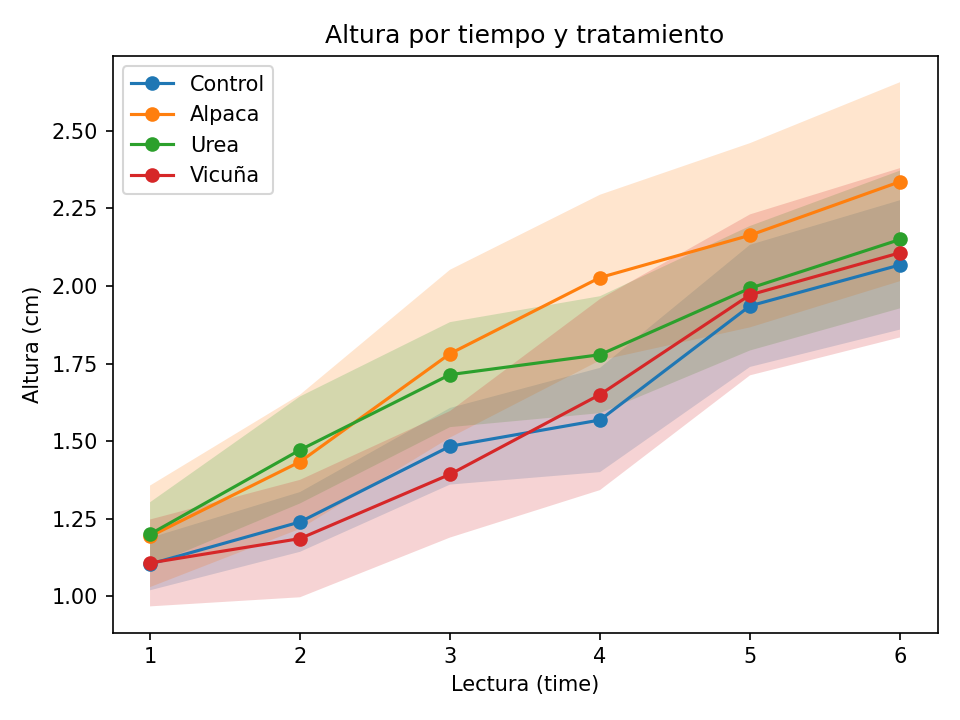

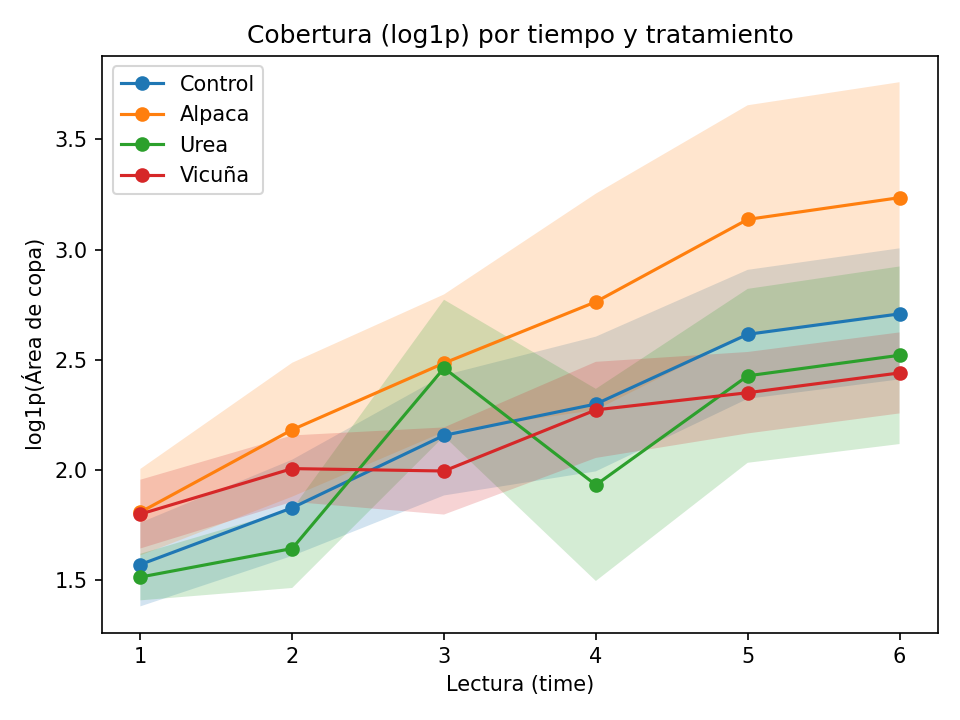

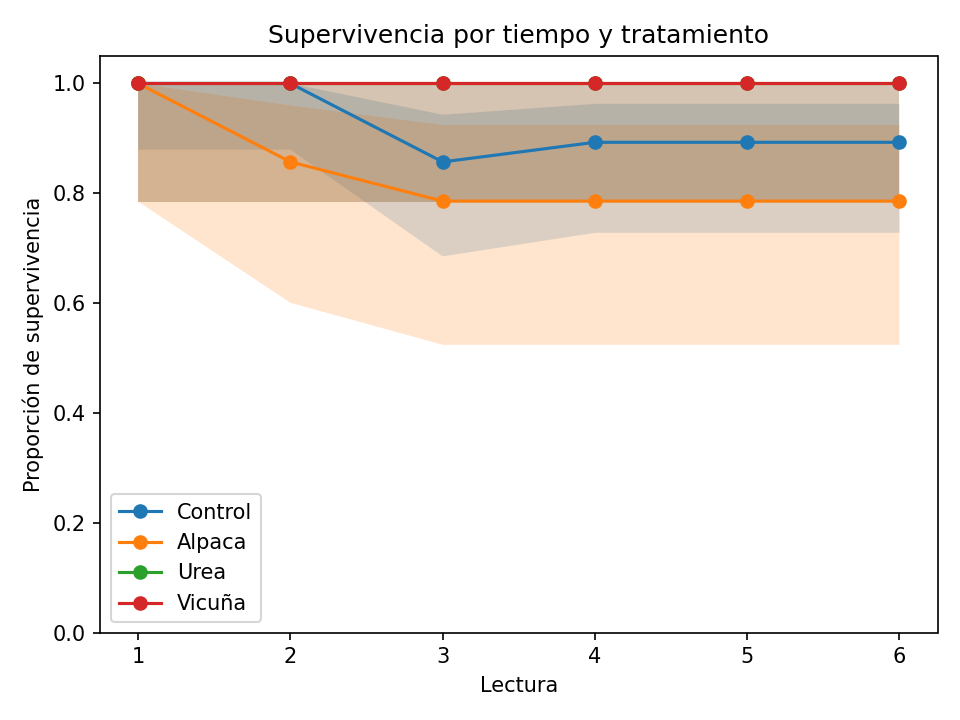

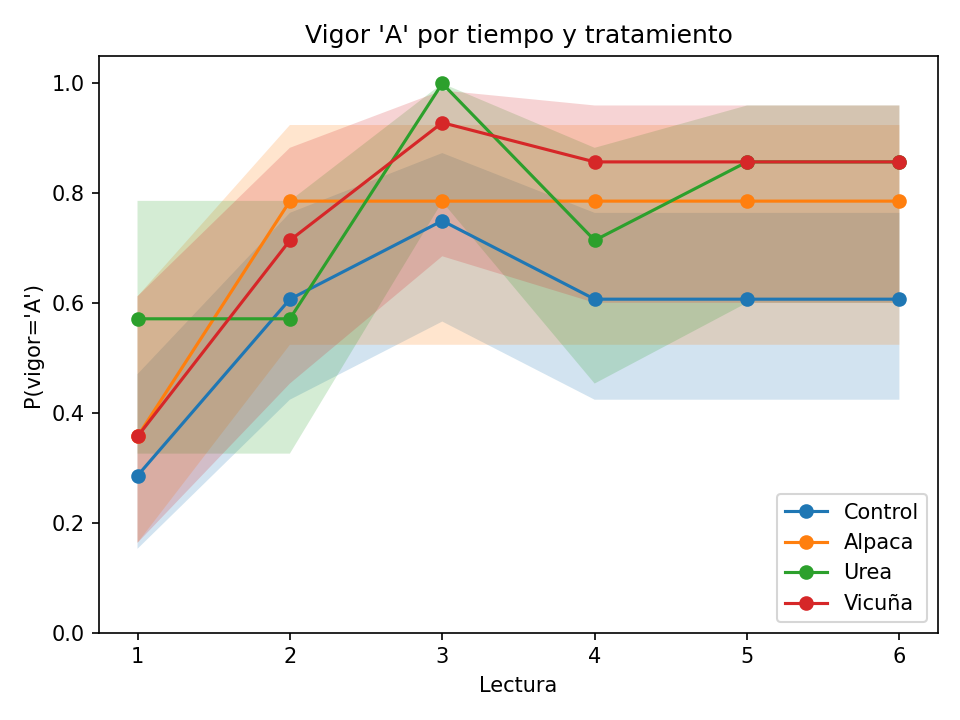

[PDF] Guardado: out_by_species/Al_pin/Al_pin_panel.pdf

=== Cin_cur ===


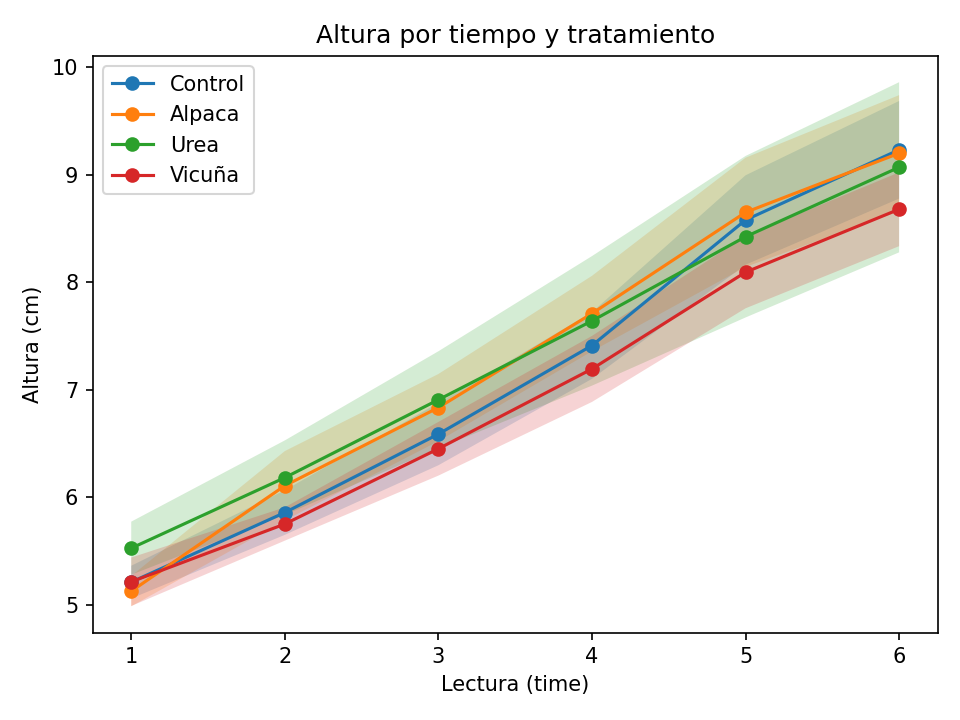

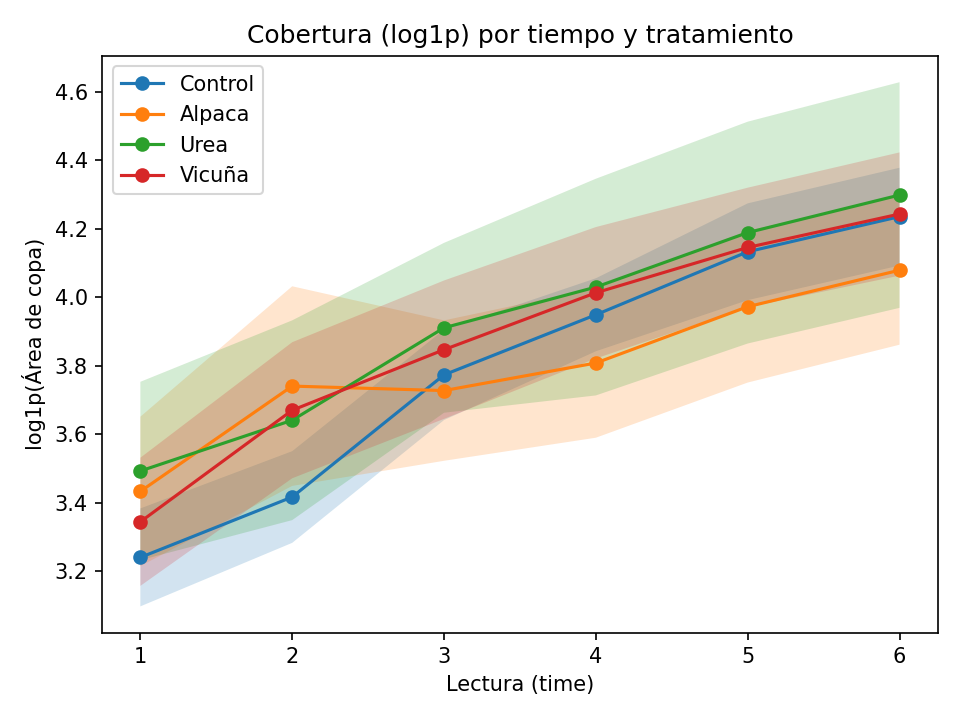

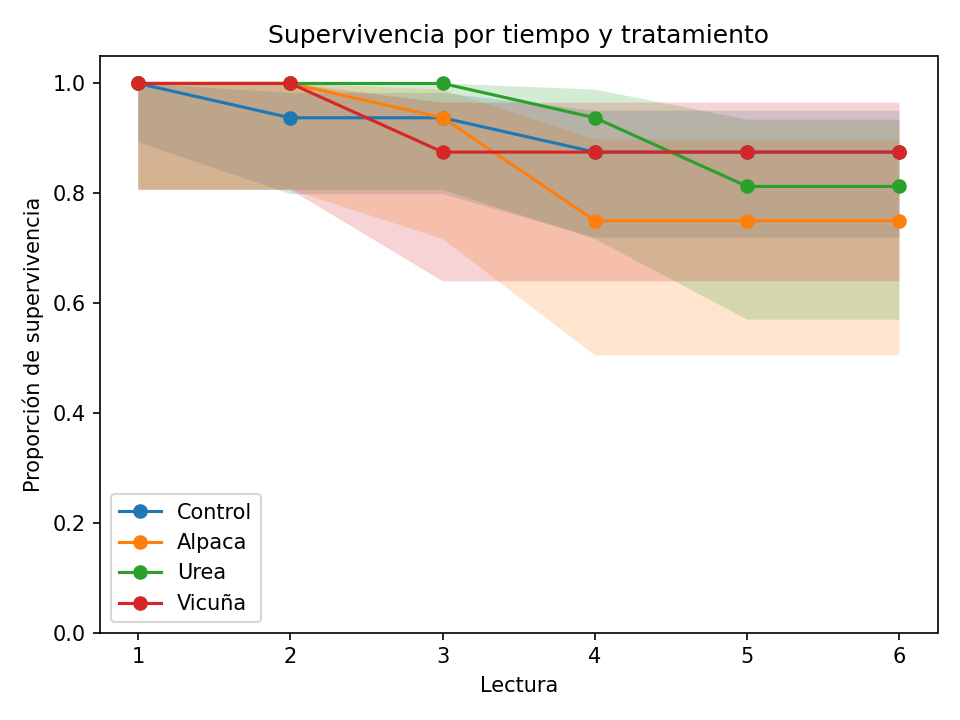

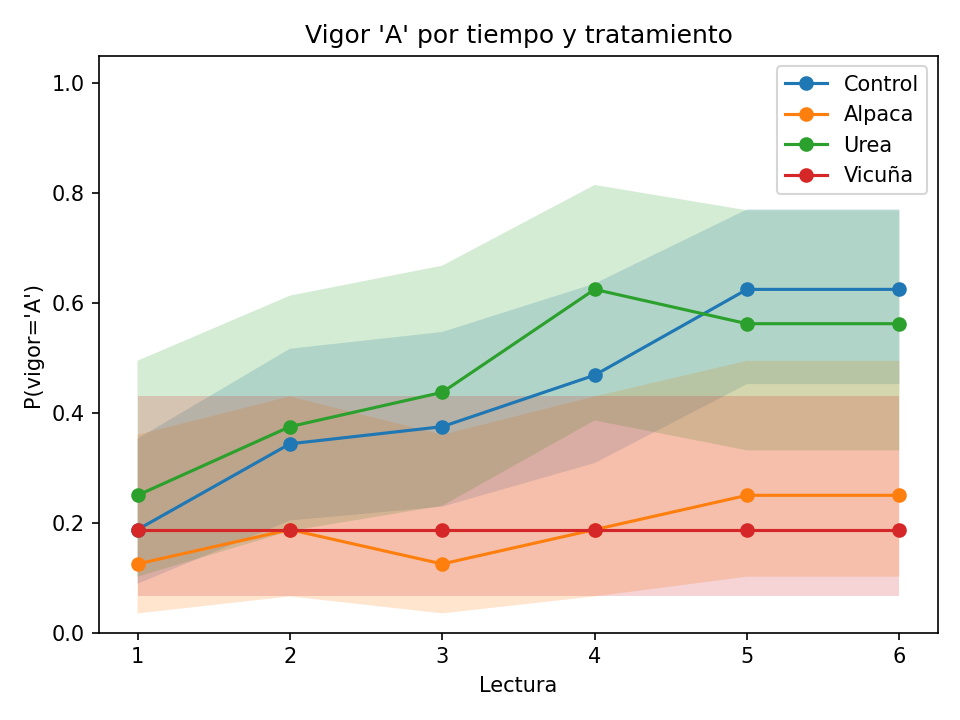

[PDF] Guardado: out_by_species/Cin_cur/Cin_cur_panel.pdf

=== Cin_vic ===


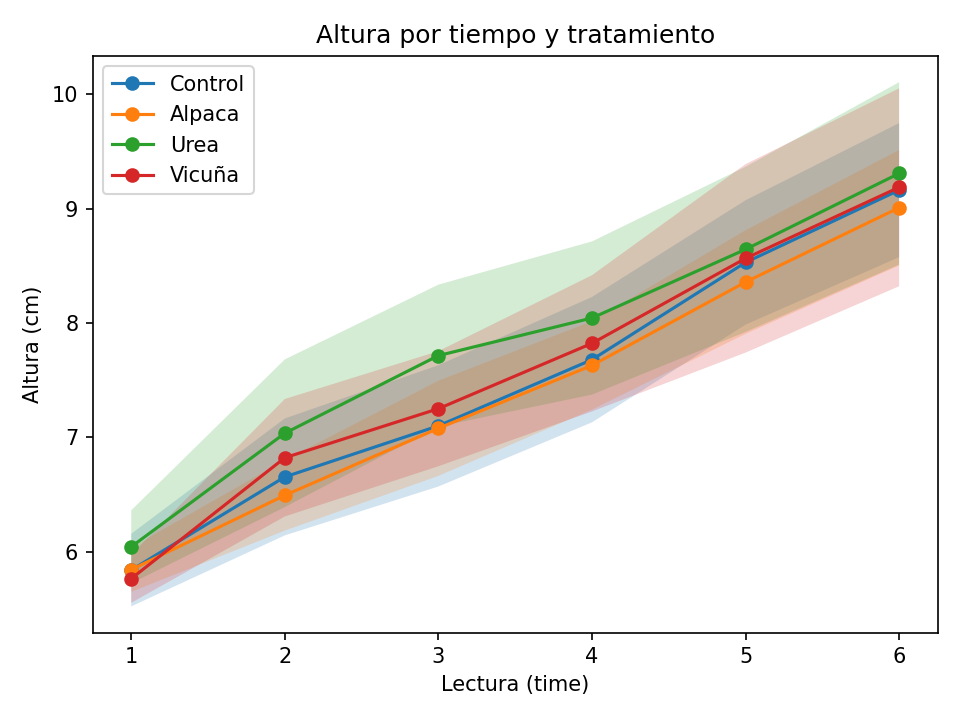

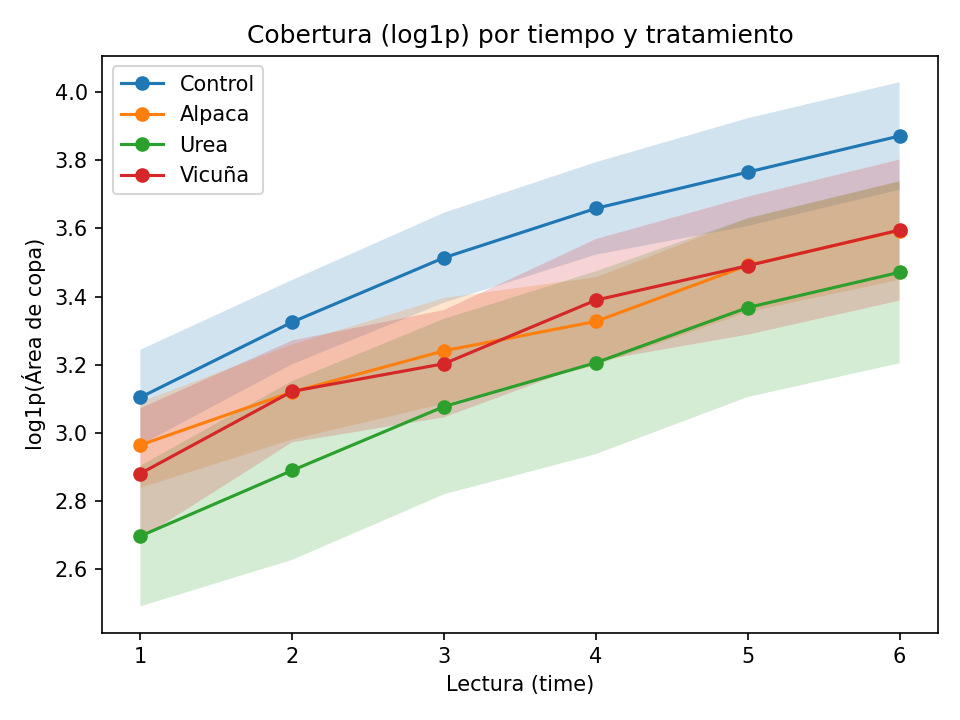

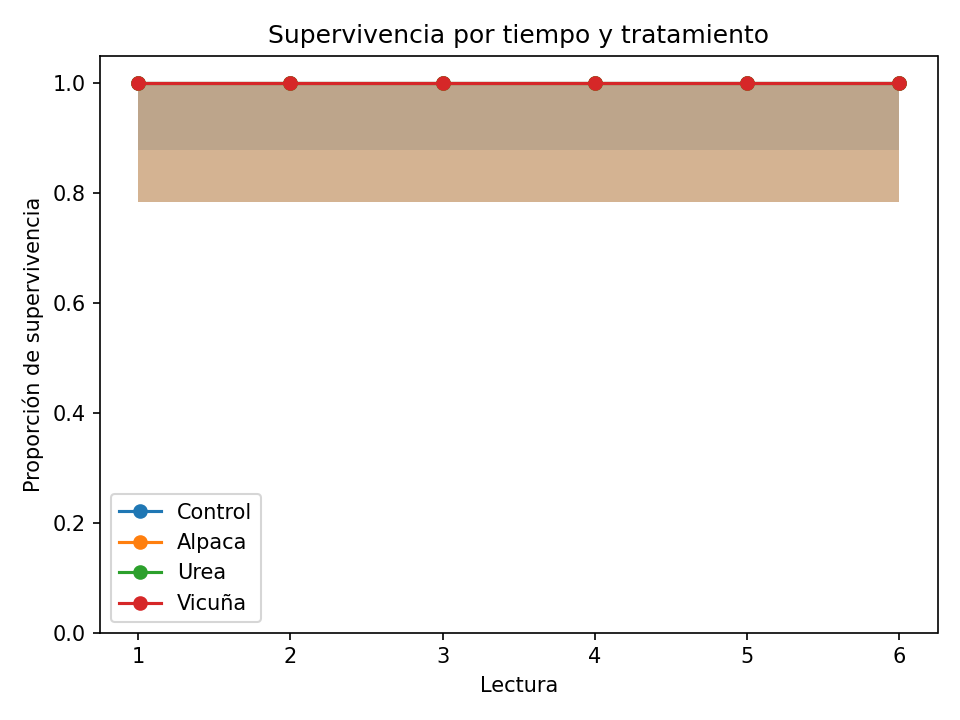

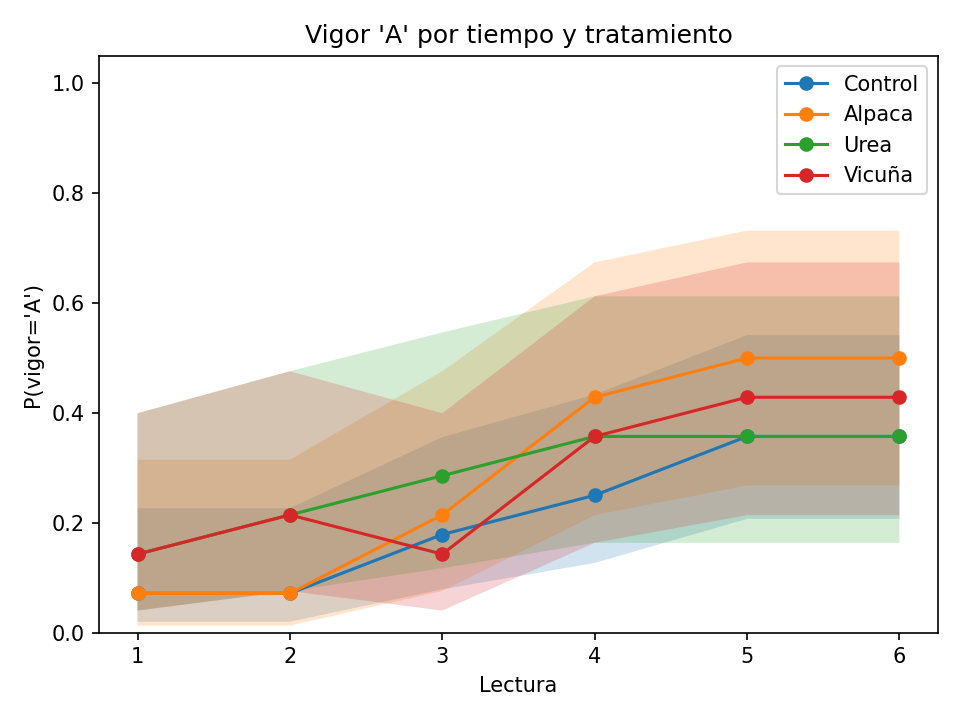

[PDF] Guardado: out_by_species/Cin_vic/Cin_vic_panel.pdf

=== Fes_dol ===


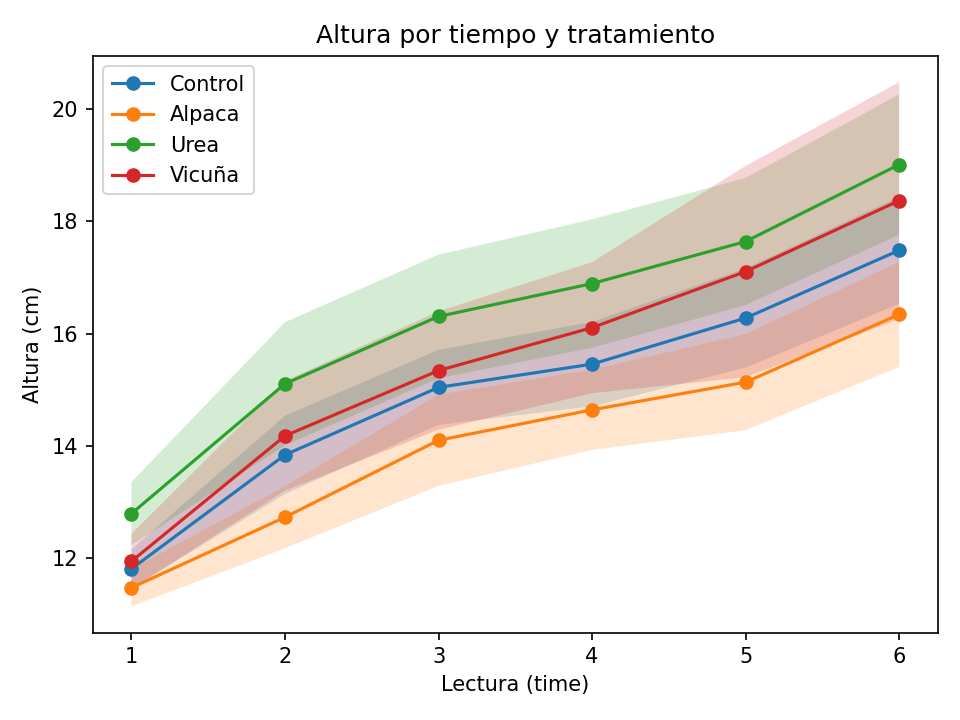

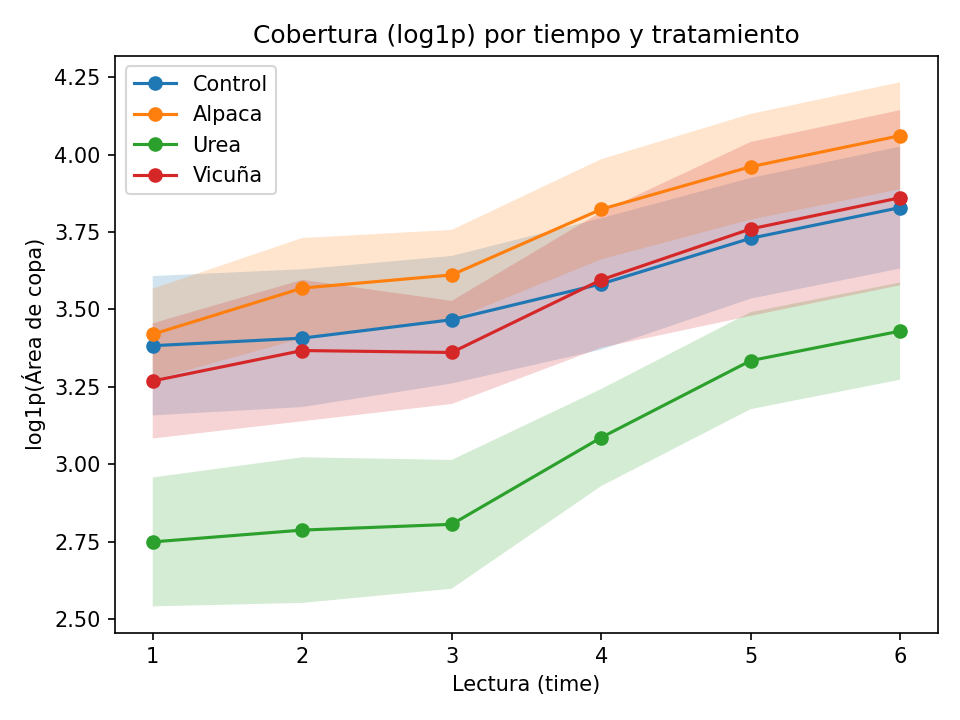

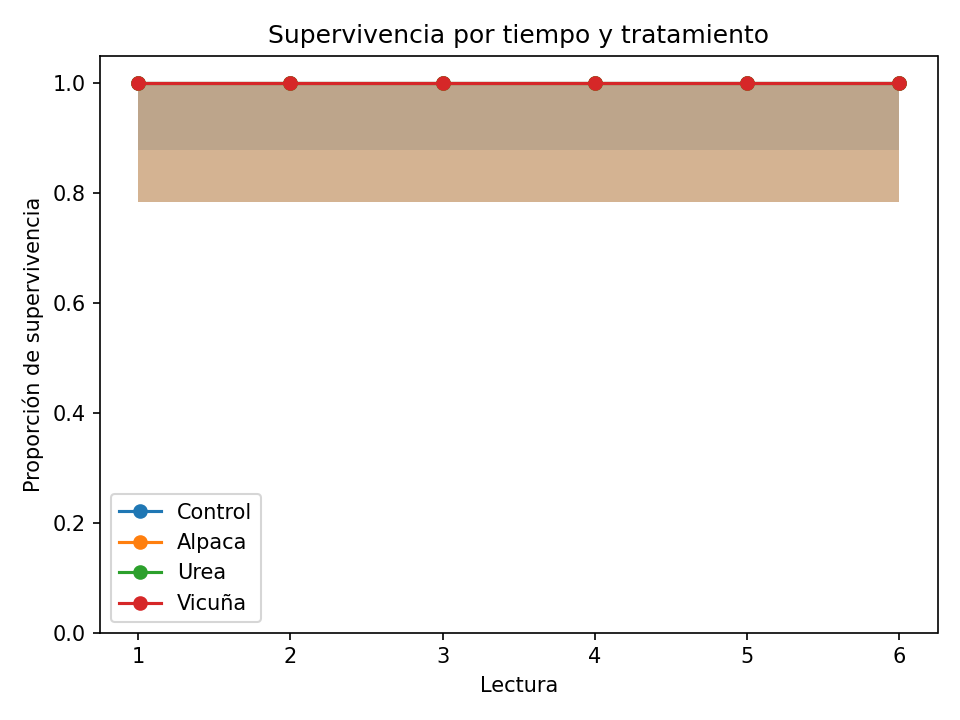

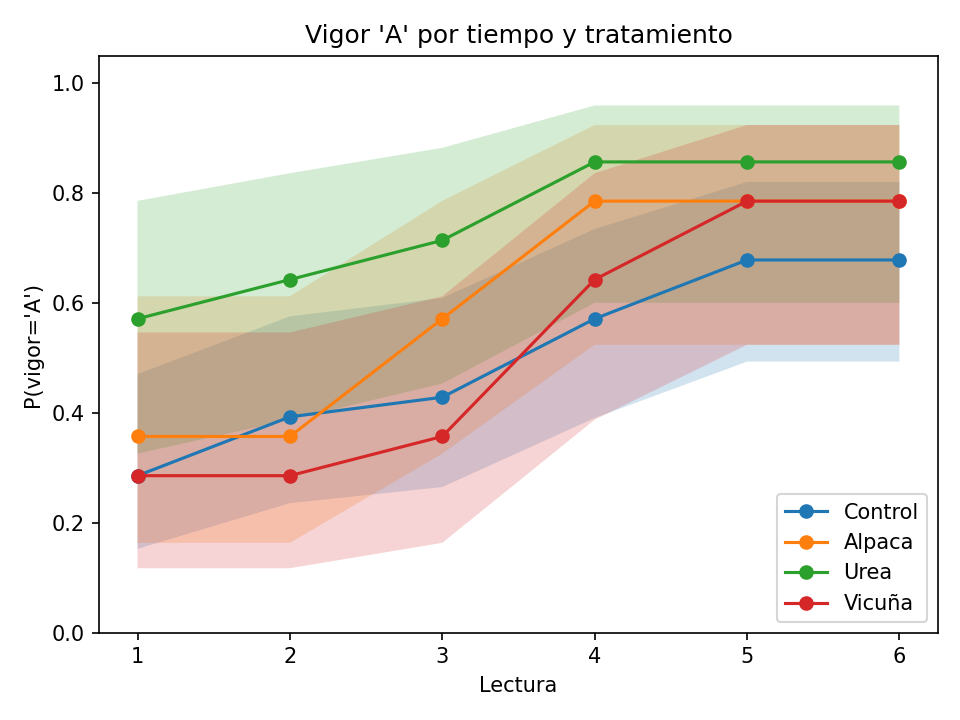

[PDF] Guardado: out_by_species/Fes_dol/Fes_dol_panel.pdf

=== Fes_rig ===


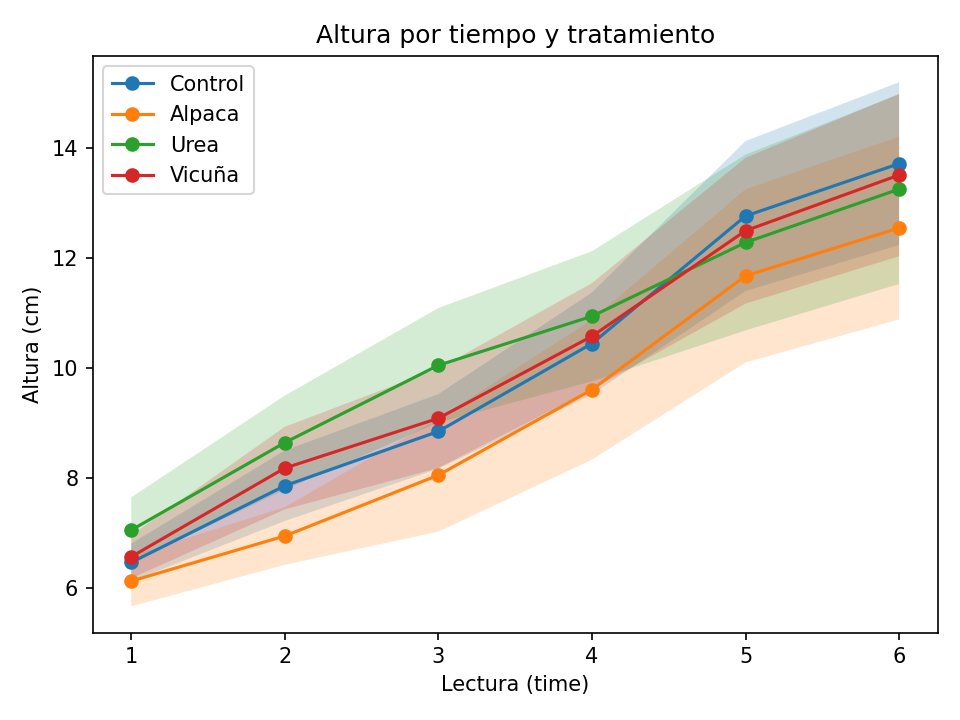

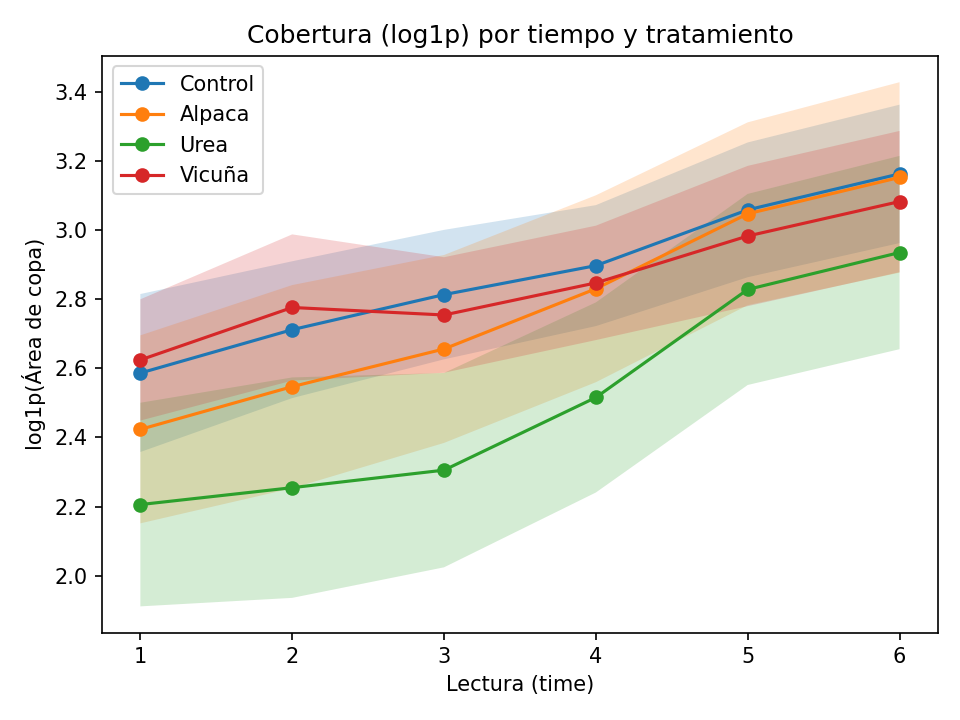

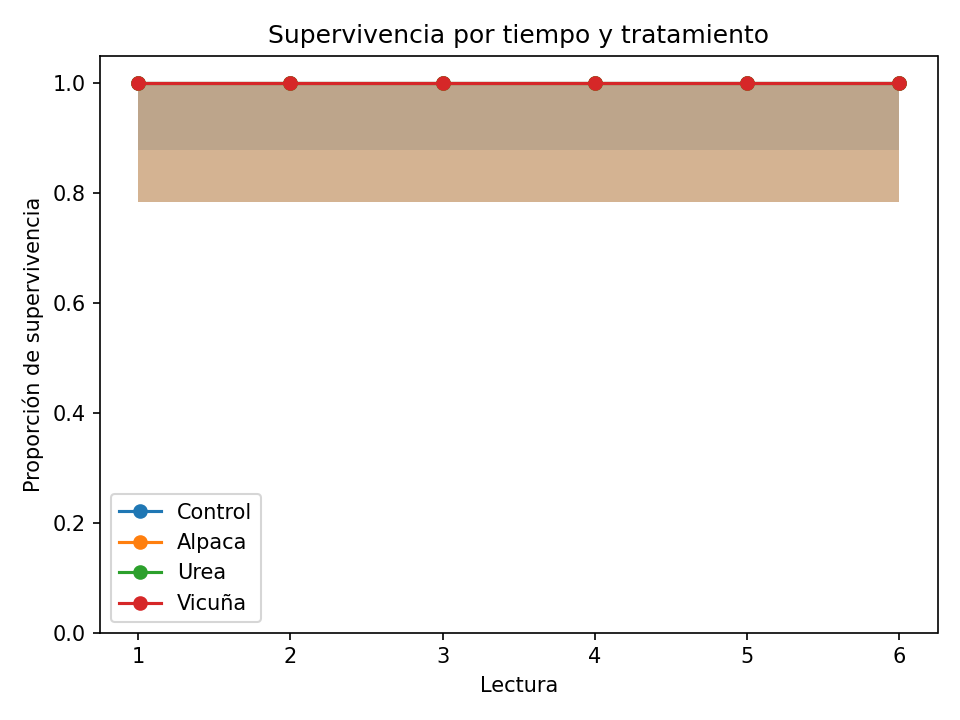

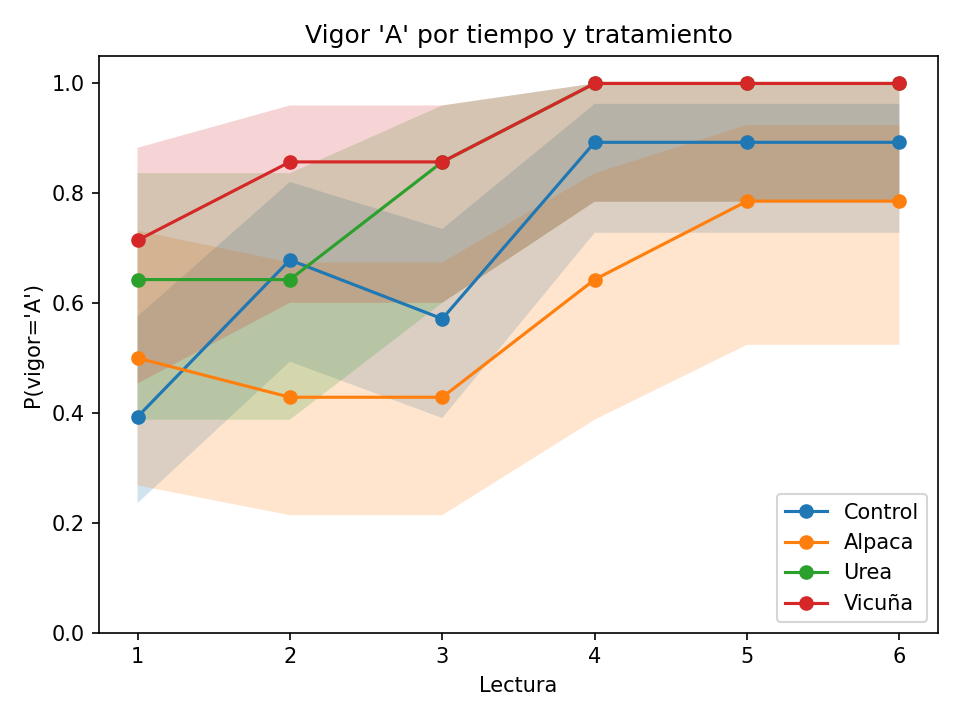

[PDF] Guardado: out_by_species/Fes_rig/Fes_rig_panel.pdf

=== Nas_sp ===


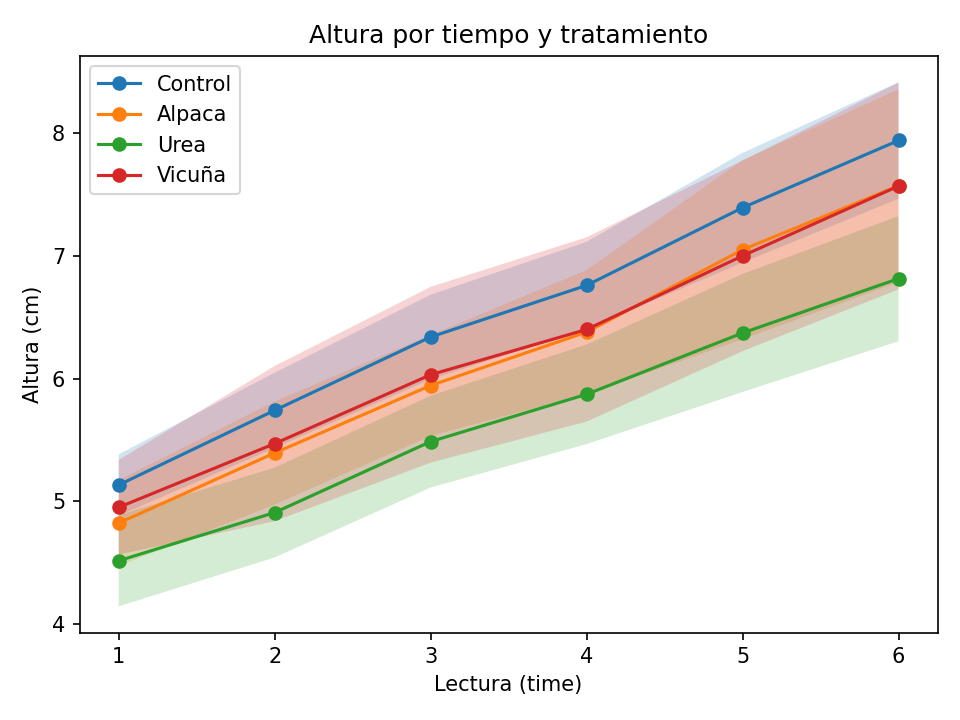

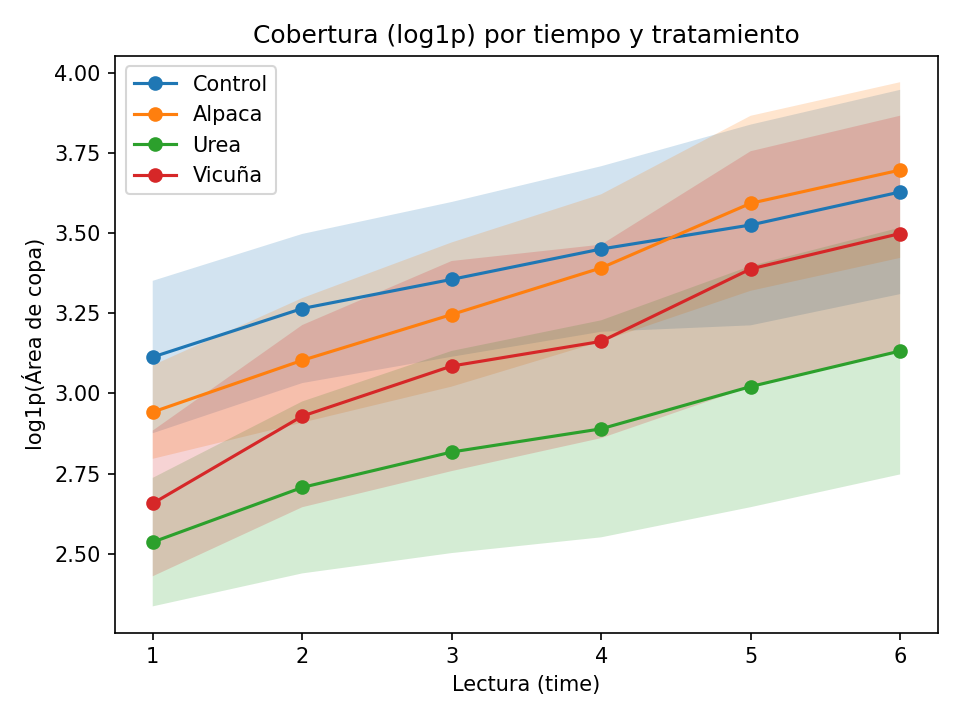

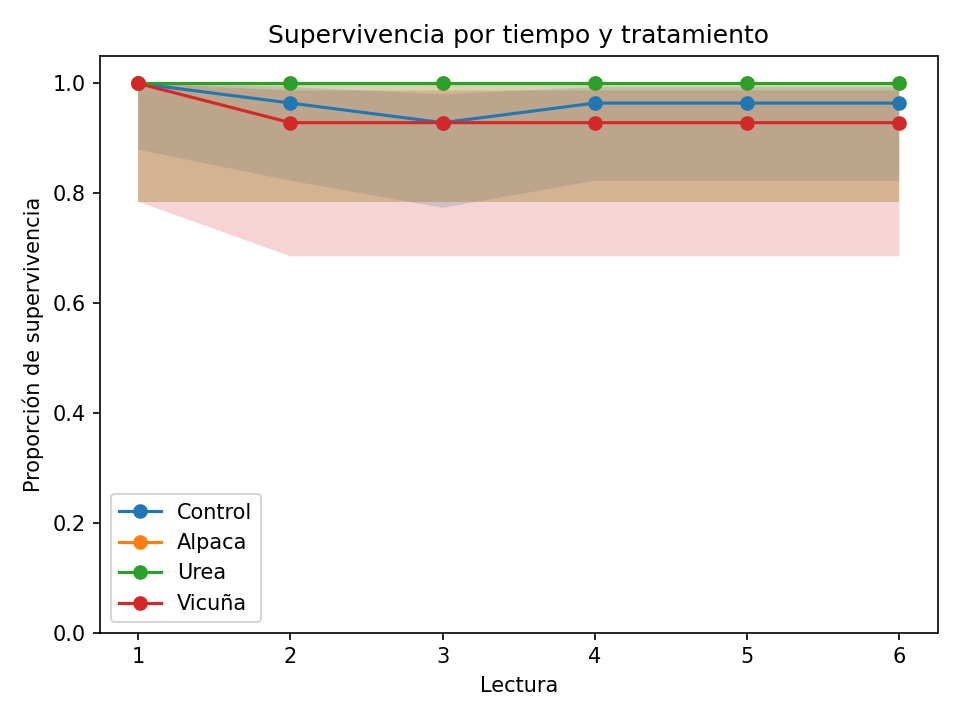

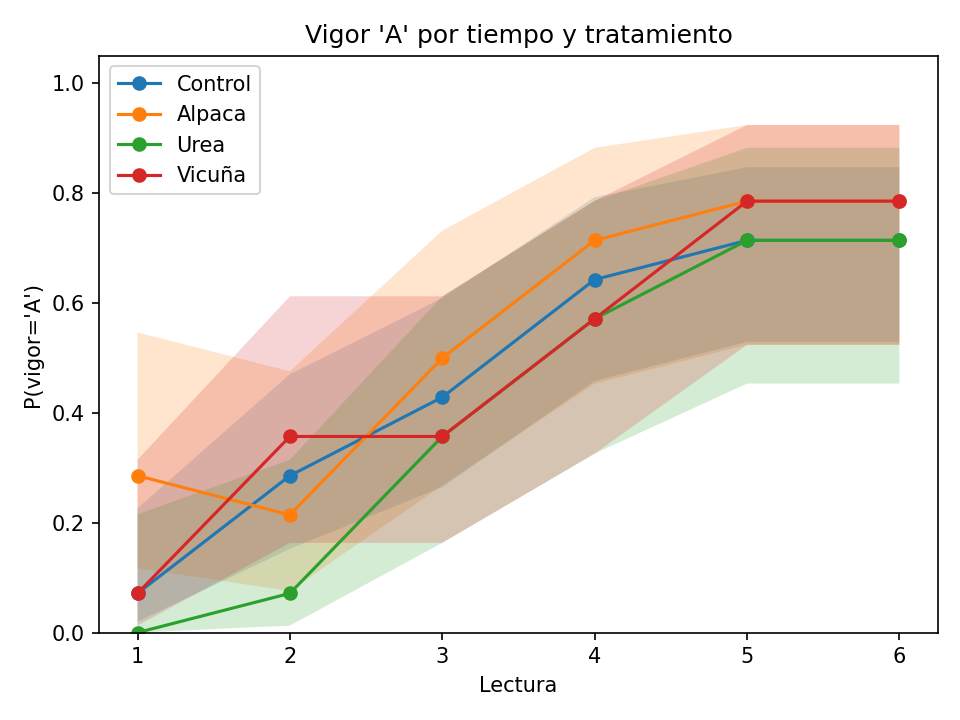

[PDF] Guardado: out_by_species/Nas_sp/Nas_sp_panel.pdf

=== Tric_rig ===


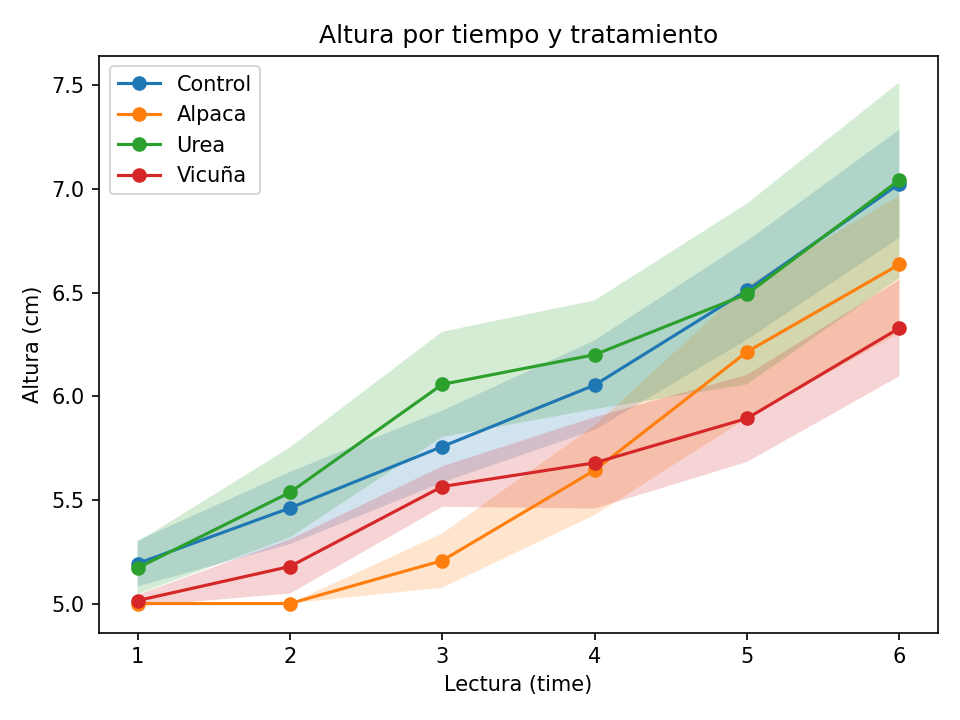

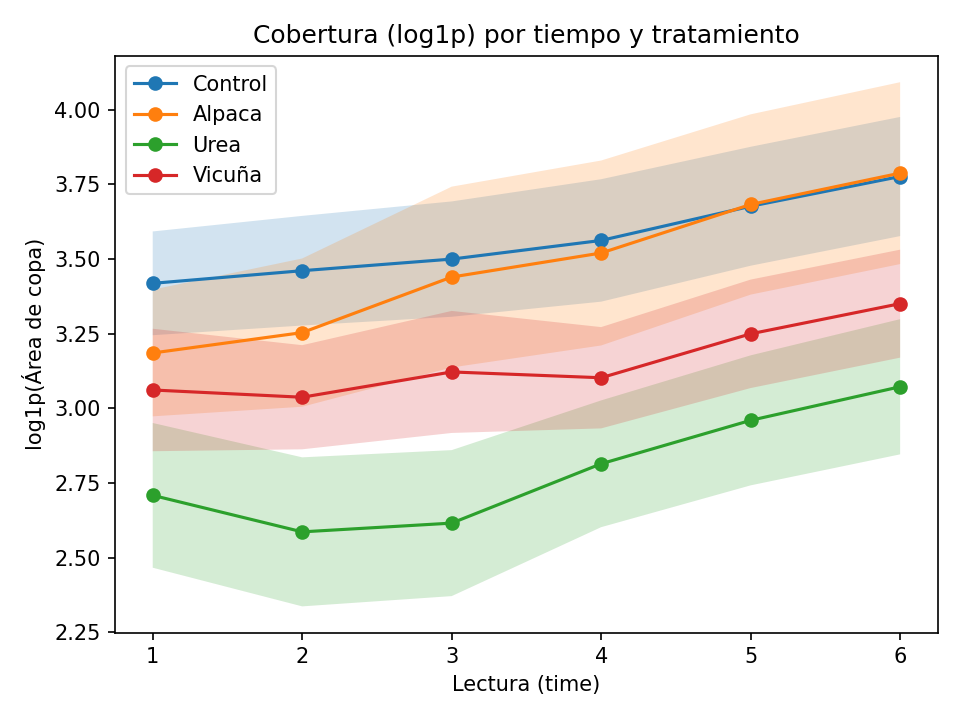

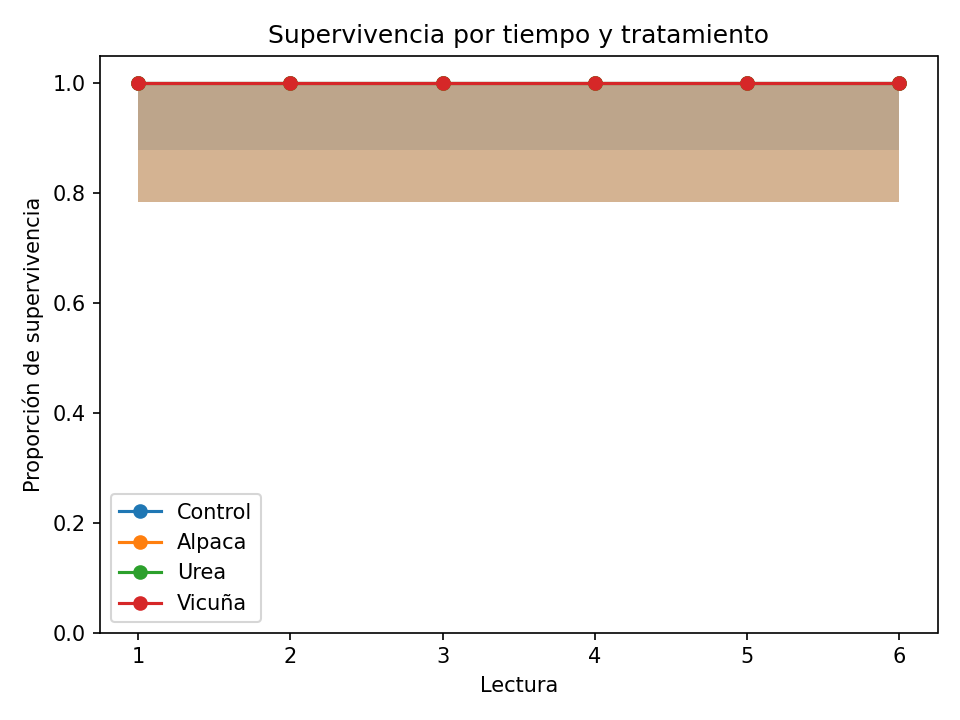

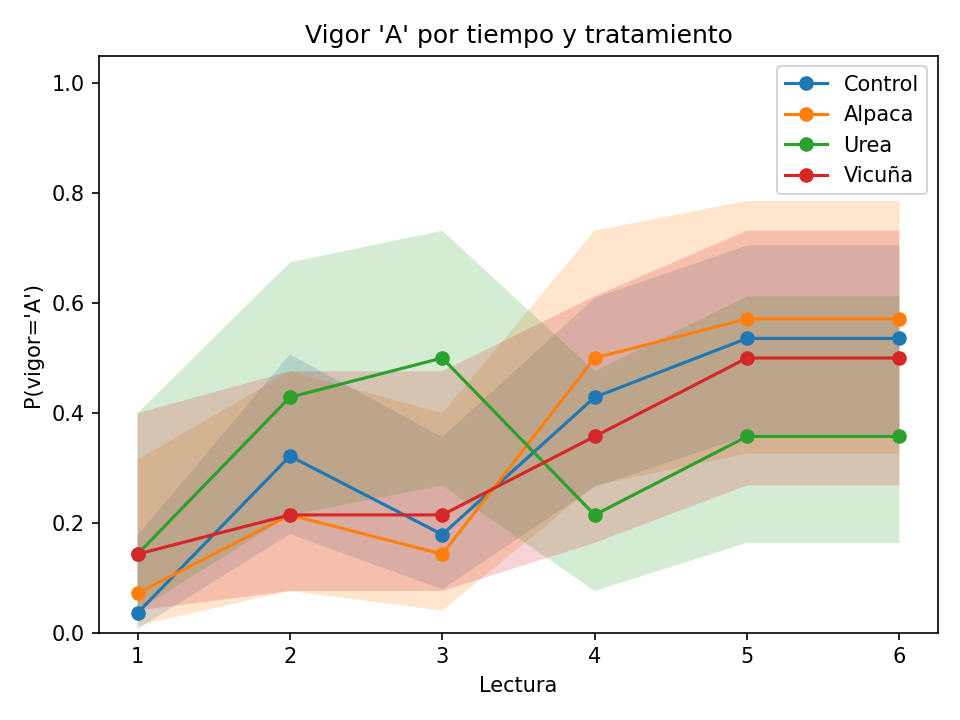

[PDF] Guardado: out_by_species/Tric_rig/Tric_rig_panel.pdf


In [ ]:
import os
from IPython.display import display, Image
from PIL import Image as PILImage

base = "out_by_species"  # carpeta que creó el script
species = sorted([d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))])

for sp in species:
    print(f"\n=== {sp} ===")
    paths = [os.path.join(base, sp, f) for f in [
        "altura_tiempo.png",
        "copa_tiempo.png",
        "supervivencia_tiempo.png",
        "vigorA_tiempo.png"
    ] if os.path.exists(os.path.join(base, sp, f))]

    # Mostrar en notebook
    for p in paths:
        display(Image(filename=p))

    # Exportar un PDF por especie (si tienes Pillow)
    if paths:
        imgs = [PILImage.open(p).convert("RGB") for p in paths]
        pdf_path = os.path.join(base, sp, f"{sp}_panel.pdf")
        imgs[0].save(pdf_path, save_all=True, append_images=imgs[1:])
        print(f"[PDF] Guardado: {pdf_path}")
